# SAE Training 

Examining SAE fidelty to see if we need to make changes to its loss function and/or how we train it.

In [1]:
import time

EXPERIMENT_TYPE = "SAE"
RUN_ID = time.time()

## SAE Params

In [2]:
HIDDEN_SIZE = 256
L1_PENALTY = 0.01

## Imports

In [3]:
import random
import copy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm

In [84]:
from graph_helpers import (plot_weights,
                    plot_activations,
                    plot_losses,
                    plot_saliency_map,
                    plot_sparse_vecs_by_image,
                    plot_top_act_images_by_feature,
                    feature_inversion,
                    plot_sparse_features
                )

In [5]:
import sys, os
from pathlib import Path

# assume cwd is project_root/data_loader
project_root = Path(os.getcwd()).parent  # go up one level to project_root
sys.path.insert(0, str(project_root))

from helpers import load_images, load_labels, visualize_image, get_edges, generate_intermediate_edge_labels

## Set Device to GPU

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"We will be using device: {device}")

We will be using device: cuda


## Load Data

In [7]:
# train data
train_images = load_images("../data/train-images-idx3-ubyte/train-images-idx3-ubyte")
train_labels = load_labels("../data/train-labels-idx1-ubyte/train-labels-idx1-ubyte")

train_images, val_images, train_labels, val_labels = train_test_split(
    train_images, train_labels,
    test_size=1/6,  # 10k validation
    stratify=train_labels,
    random_state=42  # for reproducibility
)

# test data
test_images = load_images("../data/t10k-images-idx3-ubyte/t10k-images-idx3-ubyte")
test_labels = load_labels("../data/t10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte")

In [8]:
print("Train images shape:", train_images.shape)
print("Val images shape:", val_images.shape)
print("Test images shape:", test_images.shape)

Train images shape: (50000, 28, 28)
Val images shape: (10000, 28, 28)
Test images shape: (10000, 28, 28)


## Visualize an image

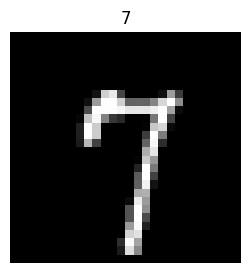

In [9]:
sample_image = train_images[0]
sample_label = train_labels[0]
visualize_image(sample_image, sample_label)

## Architecture

### NN

Once again, two hidden layers. 16 nodes each. Same as 3blue1brown.

In [10]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        layer_size_by_pixels = 28*28
        
        self.flatten = nn.Flatten()
        
        # define layers separately to have access to each
        self.hidden_one = nn.Linear(layer_size_by_pixels, 16)
        self.hidden_two = nn.Linear(16, 16)
        self.classification_layer = nn.Linear(16, 10)
        
        self.activation_function = nn.ReLU()

    def forward(self, x, hidden_one_act=None, hidden_two_act=None):
        x = self.flatten(x)

        # first hidden layer
        if hidden_one_act is None:
            hidden_one_out = self.hidden_one(x)
            hidden_one_act = self.activation_function(hidden_one_out)

        # second hidden layer
        if hidden_two_act is None:
            hidden_two_out = self.hidden_two(hidden_one_act)
            hidden_two_act = self.activation_function(hidden_two_out)

        # classification layer
        classification_out = self.classification_layer(hidden_two_act)
        
        return classification_out, hidden_one_act, hidden_two_act

In [11]:
# for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [12]:
model = NeuralNetwork().to(device)

# loss functions
classification_loss_fn = nn.CrossEntropyLoss()

# optimizers
optimizer = torch.optim.Adam(model.parameters())

In [13]:
print(f"Model weights (to compare below): {model.hidden_one.weight[0][:5].detach().cpu().numpy()}")

Model weights (to compare below): [ 0.02730495  0.02964314 -0.00836687  0.03280755 -0.00782513]


### SAE

In [14]:
class SparseAutoencoder(nn.Module):
    def __init__(self, input_size=16, hidden_size=128):
        super().__init__()
        self.encoder = nn.Linear(input_size, hidden_size)
        self.decoder = nn.Linear(hidden_size, input_size)
        self.activation = nn.ReLU()
    
    def forward(self, x):
        encoded = self.activation(self.encoder(x))
        reconstructed = self.decoder(encoded)
        return reconstructed, encoded
    
    def loss(self, x, reconstructed, encoded, l1_lambda=0.001):
        mse_loss = nn.MSELoss()(reconstructed, x)
        l1_loss = l1_lambda * torch.mean(torch.abs(encoded))
        return mse_loss + l1_loss

In [15]:
# for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
sae_hidden_two = SparseAutoencoder(input_size=16, hidden_size=HIDDEN_SIZE).to(device)
optimizer_sae_hidden_two = torch.optim.Adam(sae_hidden_two.parameters())

In [16]:
# expectation: SAE weights: [ 0.19113463  0.20750198 -0.05856812  0.22965282 -0.05477589]
print(f"SAE weights: {sae_hidden_two.encoder.weight[0][:5].detach().cpu().numpy()}")

SAE weights: [ 0.19113463  0.20750198 -0.05856812  0.22965282 -0.05477589]


In [17]:
# for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
sae_hidden_one = SparseAutoencoder(input_size=16, hidden_size=HIDDEN_SIZE).to(device)
optimizer_sae_hidden_one = torch.optim.Adam(sae_hidden_one.parameters())

In [18]:
# expectation: SAE weights: [ 0.19113463  0.20750198 -0.05856812  0.22965282 -0.05477589]
print(f"SAE weights: {sae_hidden_one.encoder.weight[0][:5].detach().cpu().numpy()}")

SAE weights: [ 0.19113463  0.20750198 -0.05856812  0.22965282 -0.05477589]


### Verify Reproducibility

In [19]:
# reset the seed
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
    
model_compare_one = NeuralNetwork().to(device)
first_set_of_weights = model_compare_one.hidden_one.weight[0][:5].detach().cpu().numpy()
print("First set of weights:", first_set_of_weights)

# reset the seed
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

model_compare_two = NeuralNetwork().to(device)
second_set_of_weights = model_compare_two.hidden_one.weight[0][:5].detach().cpu().numpy()
print("Second set of weights:", second_set_of_weights)

print(f"Are the two sets equal: {first_set_of_weights == second_set_of_weights}")

First set of weights: [ 0.02730495  0.02964314 -0.00836687  0.03280755 -0.00782513]
Second set of weights: [ 0.02730495  0.02964314 -0.00836687  0.03280755 -0.00782513]
Are the two sets equal: [ True  True  True  True  True]


## Dataloader

In [20]:
class EdgeDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        assert len(self.images) == len(self.labels)
        return len(self.images)

    def __getitem__(self, idx):
        return (
            torch.from_numpy(self.images[idx].copy()).float(),
            torch.tensor(self.labels[idx].copy(), dtype=torch.long),
        )

In [21]:
# for reproducibility on training
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

generator = torch.Generator().manual_seed(seed)

In [22]:
NUM_WORKERS = 4
if device.type.lower() == "cpu":
    NUM_WORKERS = 0

# training data
train_dataset = EdgeDataset(train_images, train_labels)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=NUM_WORKERS, worker_init_fn=seed_worker, generator=generator)

# validation data
val_dataset = EdgeDataset(val_images, val_labels)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=NUM_WORKERS)  # larger batch size for faster validation

# test data
test_dataset = EdgeDataset(test_images, test_labels)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=NUM_WORKERS)

## Training Loop

We have now incorporated fidelity as a metric for our SAEs. Ideally, fidelity should be close to 0.

The formula: (l_sae - l_x) / (l_ablated - l_x). We'd expect l_ablated to be quite high, so our denominator should be positive as l_ablated >> l_x. Ideally, l_sae is a good approximation of l_x, so our numerator should approach 0. 

This metric, while it doesn't affect the training of the SAE, should tell us how the SAE performs downstream with the classifer. This is a good step prior to 1) making the SAE training changes and 2) thinking about decoupling the SAE to train for longer.

In [23]:
best_model = None
best_sae_one = None
best_sae_two = None
num_epochs = 20

best_val_acc = 0.0
best_val_loss = float('inf')

validation_losses = []
training_losses = []
SAE_hidden_one_losses = []
SAE_hidden_two_losses = []

# Initialize storage for training features and labels
feature_activations_one_train = torch.zeros(HIDDEN_SIZE, len(train_loader.dataset))
feature_activations_two_train = torch.zeros(HIDDEN_SIZE, len(train_loader.dataset))
labels_train = torch.zeros(len(train_loader.dataset), dtype=torch.long)

for epoch in range(num_epochs):
    # --- Training Phase ---
    model.train()  # set the model to training mode - this is currently a no-op
    sae_hidden_two.train()
    sae_hidden_one.train()
    
    train_loss = 0.0
    total_sae_loss_hidden_two = 0.0
    total_sae_loss_hidden_one = 0.0

    train_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs} [Train]", leave=False)
    for batch_idx, batch in enumerate(train_bar):
        # deconstruct batch items
        images, labels = batch
        images, labels = images.to(device), labels.to(device)
        
        # forward pass
        classification_out, hidden_act_one, hidden_act_two = model(images)

        # Classification loss and backprop
        optimizer.zero_grad()
        total_loss = classification_loss_fn(classification_out, labels)
        total_loss.backward()
        optimizer.step()
        train_loss += total_loss.item()
        train_bar.set_postfix(loss=total_loss.item())

        # to prevent backprop on both graphs:
        hidden_act_one_detached = hidden_act_one.detach()
        hidden_act_two_detached = hidden_act_two.detach()

        # SAE loss and backprop - hidden layer one
        optimizer_sae_hidden_one.zero_grad()
        reconstructed_one, encoded_one = sae_hidden_one(hidden_act_one_detached)
        sae_loss_hidden_one = sae_hidden_one.loss(hidden_act_one_detached,
                                                  reconstructed_one,
                                                  encoded_one,
                                                  l1_lambda=L1_PENALTY
                                                 )
        sae_loss_hidden_one.backward()
        optimizer_sae_hidden_one.step()
        total_sae_loss_hidden_one += sae_loss_hidden_one.item()
        
        # SAE loss and backprop - hidden layer two
        optimizer_sae_hidden_two.zero_grad()
        reconstructed_two, encoded_two = sae_hidden_two(hidden_act_two_detached)
        sae_loss_hidden_two = sae_hidden_two.loss(hidden_act_two_detached,
                                                  reconstructed_two,
                                                  encoded_two,
                                                  l1_lambda=L1_PENALTY
                                                 )
        sae_loss_hidden_two.backward()
        optimizer_sae_hidden_two.step()
        total_sae_loss_hidden_two += sae_loss_hidden_two.item()

        # Store training features and labels
        start_idx = batch_idx * train_loader.batch_size
        end_idx = start_idx + images.size(0)
        feature_activations_one_train[:, start_idx:end_idx] = encoded_one.T.cpu()
        feature_activations_two_train[:, start_idx:end_idx] = encoded_two.T.cpu()
        labels_train[start_idx:end_idx] = labels.cpu()

    # --- Validation Phase ---
    model.eval()
    sae_hidden_one.eval()
    sae_hidden_two.eval()
    val_loss = 0.0
    val_sae_loss_one = 0.0
    val_sae_loss_two = 0.0
    val_sae_loss_one_ablated = 0.0 
    val_sae_loss_two_ablated = 0.0 

    correct = 0
    correct_one = 0
    correct_two = 0
    total = 0
    
    val_bar = tqdm(val_loader, desc=f"Epoch {epoch + 1}/{num_epochs} [Val]", leave=False)
    with torch.no_grad():
        for batch in val_bar:
            # deconstruct
            images, labels = batch
            images, labels = images.to(device), labels.to(device)

            # forward pass
            classification_out, hidden_act_one, hidden_act_two = model(images)

            hidden_act_one_detached = hidden_act_one.detach()
            hidden_act_two_detached = hidden_act_two.detach()

            # compute loss
            loss = classification_loss_fn(classification_out, labels)

            # get reconstructions
            reconstructed_one, _ = sae_hidden_one(hidden_act_one_detached)
            reconstructed_two, _ = sae_hidden_two(hidden_act_two_detached)

            # losses for fidelity - layer one
            classification_out_sae_one, _, _ = model(images, hidden_one_act=reconstructed_one)
            l_sae_one = classification_loss_fn(classification_out_sae_one, labels)
            val_sae_loss_one += l_sae_one.item()

            _, predicted_one = torch.max(classification_out_sae_one, 1)
            correct_one += (predicted_one == labels).sum().item()

            zero_act_one = torch.zeros_like(hidden_act_one_detached)
            classification_out_sae_one_ablated, _, _ = model(images, hidden_one_act=zero_act_one)
            l_ablated_one = classification_loss_fn(classification_out_sae_one_ablated, labels)
            val_sae_loss_one_ablated += l_ablated_one.item()
        
            # losses for fidelity - layer two
            classification_out_sae_two, _, _ = model(images, hidden_one_act=hidden_act_one_detached, hidden_two_act=reconstructed_two)
            l_sae_two = classification_loss_fn(classification_out_sae_two, labels)
            val_sae_loss_two += l_sae_two.item()

            _, predicted_two = torch.max(classification_out_sae_two, 1)
            correct_two += (predicted_two == labels).sum().item()

            zero_act_two = torch.zeros_like(hidden_act_two_detached)
            classification_out_sae_two_ablated, _, _ = model(images, hidden_one_act=hidden_act_one_detached, hidden_two_act=zero_act_two)
            l_ablated_two = classification_loss_fn(classification_out_sae_two_ablated, labels)
            val_sae_loss_two_ablated += l_ablated_two.item()

            # calculate metrics
            val_loss += loss.item()
            _, predicted = torch.max(classification_out, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    # epoch stats
    avg_train_loss = train_loss / len(train_loader)
    avg_sae_train_loss_hidden_one = total_sae_loss_hidden_one / len(train_loader)
    avg_sae_train_loss_hidden_two = total_sae_loss_hidden_two / len(train_loader)

    avg_val_loss = val_loss / len(val_loader)
    avg_sae_loss_one = val_sae_loss_one / len(val_loader)
    avg_sae_loss_one_ablated = val_sae_loss_one_ablated / len(val_loader)
    avg_sae_loss_two = val_sae_loss_two / len(val_loader)
    avg_sae_loss_two_ablated = val_sae_loss_two_ablated / len(val_loader)
    val_accuracy = 100 * correct / total
    val_accuracy_sae_one = 100 * correct_one / total
    val_accuracy_sae_two = 100 * correct_two / total

    epsilon = 1e-8
    fidelity_one = (avg_sae_loss_one - avg_val_loss) / (avg_sae_loss_one_ablated - avg_val_loss + epsilon)
    fidelity_two = (avg_sae_loss_two - avg_val_loss) / (avg_sae_loss_two_ablated - avg_val_loss + epsilon)
    
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"  Training Metrics:")
    print(f"    Train Loss: {avg_train_loss:.4f}")
    print(f"    SAE Train Loss (hidden one): {avg_sae_train_loss_hidden_one:.4f}")
    print(f"    SAE Train Loss (hidden two): {avg_sae_train_loss_hidden_two:.4f}")

    print(f"  Validation Metrics:")
    print(f"    Baseline Loss (val): {avg_val_loss:.4f}")
    print(f"    SAE Loss (hidden one): {avg_sae_loss_one:.4f}, Ablated: {avg_sae_loss_one_ablated:.4f}")
    print(f"    SAE Loss (hidden two): {avg_sae_loss_two:.4f}, Ablated: {avg_sae_loss_two_ablated:.4f}")
    print(f"    SAE Fidelity (hidden one): {fidelity_one:.4f}")
    print(f"    SAE Fidelity (hidden two): {fidelity_two:.4f}")
    print(f"    Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.2f}%")
    print(f"    Val Acc (one): {val_accuracy_sae_one:.4f} | Val Acc (two): {val_accuracy_sae_two:.2f}%")

    model_path = f'./models/{EXPERIMENT_TYPE}/{RUN_ID}/best_model_baseline_{epoch+1}.pth'
    os.makedirs(os.path.dirname(model_path), exist_ok=True)
    if val_accuracy > best_val_acc:
        best_val_acc = val_accuracy
        best_val_loss = avg_val_loss  # Update loss for reference
        torch.save(model.state_dict(), model_path)
        print(f"  Saved model with Val Acc: {val_accuracy:.2f}%")

        best_model = copy.deepcopy(model)
        best_sae_one = copy.deepcopy(sae_hidden_one)
        best_sae_two = copy.deepcopy(sae_hidden_two)
        
    # Optional: Save if accuracy is equal but loss is lower
    elif val_accuracy == best_val_acc and avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), model_path)
        print(f"  Saved model with same Val Acc: {val_accuracy:.2f}% but lower Val Loss: {avg_val_loss:.4f}")

        best_model = copy.deepcopy(model)
        best_sae_one = copy.deepcopy(sae_hidden_one)
        best_sae_two = copy.deepcopy(sae_hidden_two)

    validation_losses.append(avg_val_loss)
    training_losses.append(avg_train_loss)
    SAE_hidden_one_losses.append(avg_sae_train_loss_hidden_one)
    SAE_hidden_two_losses.append(avg_sae_train_loss_hidden_two)

    # plot_weights(model, epoch, EXPERIMENT_TYPE, RUN_ID)

Epoch 1/20
  Training Metrics:
    Train Loss: 1.0223
    SAE Train Loss (hidden one): 8.8025
    SAE Train Loss (hidden two): 1.1771
  Validation Metrics:
    Baseline Loss (val): 0.5656
    SAE Loss (hidden one): 0.5678, Ablated: 2.3943
    SAE Loss (hidden two): 0.5632, Ablated: 2.3305
    SAE Fidelity (hidden one): 0.0012
    SAE Fidelity (hidden two): -0.0014
    Val Loss: 0.5656 | Val Acc: 83.62%
    Val Acc (one): 83.6600 | Val Acc (two): 83.77%
  Saved model with Val Acc: 83.62%


Epoch 2/20
  Training Metrics:
    Train Loss: 0.4646
    SAE Train Loss (hidden one): 0.5374
    SAE Train Loss (hidden two): 0.1031
  Validation Metrics:
    Baseline Loss (val): 0.4460
    SAE Loss (hidden one): 0.4475, Ablated: 2.4133
    SAE Loss (hidden two): 0.4481, Ablated: 2.3366
    SAE Fidelity (hidden one): 0.0007
    SAE Fidelity (hidden two): 0.0011
    Val Loss: 0.4460 | Val Acc: 86.46%
    Val Acc (one): 86.4200 | Val Acc (two): 86.45%
  Saved model with Val Acc: 86.46%


Epoch 3/20
  Training Metrics:
    Train Loss: 0.3924
    SAE Train Loss (hidden one): 0.5168
    SAE Train Loss (hidden two): 0.0914
  Validation Metrics:
    Baseline Loss (val): 0.3987
    SAE Loss (hidden one): 0.3977, Ablated: 2.4429
    SAE Loss (hidden two): 0.4019, Ablated: 2.3440
    SAE Fidelity (hidden one): -0.0005
    SAE Fidelity (hidden two): 0.0017
    Val Loss: 0.3987 | Val Acc: 88.16%
    Val Acc (one): 88.2400 | Val Acc (two): 88.05%
  Saved model with Val Acc: 88.16%


Epoch 4/20
  Training Metrics:
    Train Loss: 0.3673
    SAE Train Loss (hidden one): 0.5392
    SAE Train Loss (hidden two): 0.0826
  Validation Metrics:
    Baseline Loss (val): 0.3996
    SAE Loss (hidden one): 0.3990, Ablated: 2.4852
    SAE Loss (hidden two): 0.3994, Ablated: 2.3555
    SAE Fidelity (hidden one): -0.0003
    SAE Fidelity (hidden two): -0.0001
    Val Loss: 0.3996 | Val Acc: 88.18%
    Val Acc (one): 88.2000 | Val Acc (two): 88.25%
  Saved model with Val Acc: 88.18%


Epoch 5/20
  Training Metrics:
    Train Loss: 0.3517
    SAE Train Loss (hidden one): 0.5301
    SAE Train Loss (hidden two): 0.0762
  Validation Metrics:
    Baseline Loss (val): 0.3552
    SAE Loss (hidden one): 0.3553, Ablated: 2.5351
    SAE Loss (hidden two): 0.3555, Ablated: 2.3689
    SAE Fidelity (hidden one): 0.0000
    SAE Fidelity (hidden two): 0.0002
    Val Loss: 0.3552 | Val Acc: 89.42%
    Val Acc (one): 89.4400 | Val Acc (two): 89.30%
  Saved model with Val Acc: 89.42%


Epoch 6/20
  Training Metrics:
    Train Loss: 0.3349
    SAE Train Loss (hidden one): 0.5936
    SAE Train Loss (hidden two): 0.0750
  Validation Metrics:
    Baseline Loss (val): 0.3484
    SAE Loss (hidden one): 0.3487, Ablated: 2.5943
    SAE Loss (hidden two): 0.3486, Ablated: 2.3851
    SAE Fidelity (hidden one): 0.0002
    SAE Fidelity (hidden two): 0.0001
    Val Loss: 0.3484 | Val Acc: 89.91%
    Val Acc (one): 89.9100 | Val Acc (two): 89.83%
  Saved model with Val Acc: 89.91%


Epoch 7/20
  Training Metrics:
    Train Loss: 0.3278
    SAE Train Loss (hidden one): 0.6069
    SAE Train Loss (hidden two): 0.0731
  Validation Metrics:
    Baseline Loss (val): 0.3521
    SAE Loss (hidden one): 0.3530, Ablated: 2.6598
    SAE Loss (hidden two): 0.3539, Ablated: 2.4034
    SAE Fidelity (hidden one): 0.0004
    SAE Fidelity (hidden two): 0.0009
    Val Loss: 0.3521 | Val Acc: 89.77%
    Val Acc (one): 89.7600 | Val Acc (two): 89.76%


Epoch 8/20
  Training Metrics:
    Train Loss: 0.3185
    SAE Train Loss (hidden one): 0.6247
    SAE Train Loss (hidden two): 0.0704
  Validation Metrics:
    Baseline Loss (val): 0.3430
    SAE Loss (hidden one): 0.3424, Ablated: 2.7650
    SAE Loss (hidden two): 0.3434, Ablated: 2.4240
    SAE Fidelity (hidden one): -0.0002
    SAE Fidelity (hidden two): 0.0002
    Val Loss: 0.3430 | Val Acc: 89.99%
    Val Acc (one): 90.0600 | Val Acc (two): 90.02%
  Saved model with Val Acc: 89.99%


Epoch 9/20
  Training Metrics:
    Train Loss: 0.3092
    SAE Train Loss (hidden one): 0.6384
    SAE Train Loss (hidden two): 0.0679
  Validation Metrics:
    Baseline Loss (val): 0.3521
    SAE Loss (hidden one): 0.3515, Ablated: 2.8688
    SAE Loss (hidden two): 0.3526, Ablated: 2.4493
    SAE Fidelity (hidden one): -0.0002
    SAE Fidelity (hidden two): 0.0002
    Val Loss: 0.3521 | Val Acc: 89.41%
    Val Acc (one): 89.4500 | Val Acc (two): 89.40%


Epoch 10/20
  Training Metrics:
    Train Loss: 0.3059
    SAE Train Loss (hidden one): 0.6079
    SAE Train Loss (hidden two): 0.0648
  Validation Metrics:
    Baseline Loss (val): 0.3405
    SAE Loss (hidden one): 0.3415, Ablated: 2.9583
    SAE Loss (hidden two): 0.3400, Ablated: 2.4733
    SAE Fidelity (hidden one): 0.0004
    SAE Fidelity (hidden two): -0.0002
    Val Loss: 0.3405 | Val Acc: 90.10%
    Val Acc (one): 90.1000 | Val Acc (two): 90.16%
  Saved model with Val Acc: 90.10%


Epoch 11/20
  Training Metrics:
    Train Loss: 0.2975
    SAE Train Loss (hidden one): 0.5902
    SAE Train Loss (hidden two): 0.0635
  Validation Metrics:
    Baseline Loss (val): 0.3421
    SAE Loss (hidden one): 0.3429, Ablated: 3.0737
    SAE Loss (hidden two): 0.3410, Ablated: 2.5035
    SAE Fidelity (hidden one): 0.0003
    SAE Fidelity (hidden two): -0.0005
    Val Loss: 0.3421 | Val Acc: 90.39%
    Val Acc (one): 90.3600 | Val Acc (two): 90.32%
  Saved model with Val Acc: 90.39%


Epoch 12/20
  Training Metrics:
    Train Loss: 0.2959
    SAE Train Loss (hidden one): 0.6767
    SAE Train Loss (hidden two): 0.0629
  Validation Metrics:
    Baseline Loss (val): 0.3340
    SAE Loss (hidden one): 0.3334, Ablated: 3.2174
    SAE Loss (hidden two): 0.3340, Ablated: 2.5371
    SAE Fidelity (hidden one): -0.0002
    SAE Fidelity (hidden two): 0.0000
    Val Loss: 0.3340 | Val Acc: 90.59%
    Val Acc (one): 90.5200 | Val Acc (two): 90.50%
  Saved model with Val Acc: 90.59%


Epoch 13/20
  Training Metrics:
    Train Loss: 0.2922
    SAE Train Loss (hidden one): 0.6343
    SAE Train Loss (hidden two): 0.0592
  Validation Metrics:
    Baseline Loss (val): 0.3310
    SAE Loss (hidden one): 0.3308, Ablated: 3.3774
    SAE Loss (hidden two): 0.3317, Ablated: 2.5687
    SAE Fidelity (hidden one): -0.0001
    SAE Fidelity (hidden two): 0.0003
    Val Loss: 0.3310 | Val Acc: 90.67%
    Val Acc (one): 90.6600 | Val Acc (two): 90.77%
  Saved model with Val Acc: 90.67%


Epoch 14/20
  Training Metrics:
    Train Loss: 0.2875
    SAE Train Loss (hidden one): 0.6153
    SAE Train Loss (hidden two): 0.0569
  Validation Metrics:
    Baseline Loss (val): 0.3456
    SAE Loss (hidden one): 0.3447, Ablated: 3.5895
    SAE Loss (hidden two): 0.3453, Ablated: 2.6080
    SAE Fidelity (hidden one): -0.0003
    SAE Fidelity (hidden two): -0.0001
    Val Loss: 0.3456 | Val Acc: 89.83%
    Val Acc (one): 89.8800 | Val Acc (two): 89.87%


Epoch 15/20
  Training Metrics:
    Train Loss: 0.2879
    SAE Train Loss (hidden one): 0.6247
    SAE Train Loss (hidden two): 0.0575
  Validation Metrics:
    Baseline Loss (val): 0.3609
    SAE Loss (hidden one): 0.3607, Ablated: 3.7228
    SAE Loss (hidden two): 0.3623, Ablated: 2.6439
    SAE Fidelity (hidden one): -0.0001
    SAE Fidelity (hidden two): 0.0006
    Val Loss: 0.3609 | Val Acc: 89.51%
    Val Acc (one): 89.4500 | Val Acc (two): 89.47%


Epoch 16/20
  Training Metrics:
    Train Loss: 0.2835
    SAE Train Loss (hidden one): 0.6209
    SAE Train Loss (hidden two): 0.0530
  Validation Metrics:
    Baseline Loss (val): 0.3243
    SAE Loss (hidden one): 0.3240, Ablated: 3.9248
    SAE Loss (hidden two): 0.3249, Ablated: 2.6868
    SAE Fidelity (hidden one): -0.0001
    SAE Fidelity (hidden two): 0.0003
    Val Loss: 0.3243 | Val Acc: 90.88%
    Val Acc (one): 90.8800 | Val Acc (two): 90.87%
  Saved model with Val Acc: 90.88%


Epoch 17/20
  Training Metrics:
    Train Loss: 0.2821
    SAE Train Loss (hidden one): 0.6050
    SAE Train Loss (hidden two): 0.0534
  Validation Metrics:
    Baseline Loss (val): 0.3349
    SAE Loss (hidden one): 0.3356, Ablated: 4.0591
    SAE Loss (hidden two): 0.3346, Ablated: 2.7234
    SAE Fidelity (hidden one): 0.0002
    SAE Fidelity (hidden two): -0.0001
    Val Loss: 0.3349 | Val Acc: 90.67%
    Val Acc (one): 90.6700 | Val Acc (two): 90.70%


Epoch 18/20
  Training Metrics:
    Train Loss: 0.2784
    SAE Train Loss (hidden one): 0.6636
    SAE Train Loss (hidden two): 0.0517
  Validation Metrics:
    Baseline Loss (val): 0.3256
    SAE Loss (hidden one): 0.3254, Ablated: 4.2384
    SAE Loss (hidden two): 0.3257, Ablated: 2.7586
    SAE Fidelity (hidden one): -0.0001
    SAE Fidelity (hidden two): 0.0000
    Val Loss: 0.3256 | Val Acc: 90.95%
    Val Acc (one): 90.9400 | Val Acc (two): 91.03%
  Saved model with Val Acc: 90.95%


Epoch 19/20
  Training Metrics:
    Train Loss: 0.2754
    SAE Train Loss (hidden one): 0.6143
    SAE Train Loss (hidden two): 0.0501
  Validation Metrics:
    Baseline Loss (val): 0.3458
    SAE Loss (hidden one): 0.3455, Ablated: 4.4488
    SAE Loss (hidden two): 0.3454, Ablated: 2.7993
    SAE Fidelity (hidden one): -0.0001
    SAE Fidelity (hidden two): -0.0001
    Val Loss: 0.3458 | Val Acc: 89.98%
    Val Acc (one): 90.0200 | Val Acc (two): 90.02%


Epoch 20/20
  Training Metrics:
    Train Loss: 0.2749
    SAE Train Loss (hidden one): 0.6182
    SAE Train Loss (hidden two): 0.0488
  Validation Metrics:
    Baseline Loss (val): 0.3339
    SAE Loss (hidden one): 0.3340, Ablated: 4.6825
    SAE Loss (hidden two): 0.3339, Ablated: 2.8382
    SAE Fidelity (hidden one): 0.0000
    SAE Fidelity (hidden two): 0.0000
    Val Loss: 0.3339 | Val Acc: 90.36%
    Val Acc (one): 90.3500 | Val Acc (two): 90.34%


This seems to indicate that our SAEs are great for downstream classification... we'll have to re-run the tests on the test data again.

In [24]:
Z_train_one = feature_activations_one_train.detach().T.numpy()
Z_train_two = feature_activations_two_train.detach().T.numpy()
y_train = labels_train.numpy()

# Training Exploration

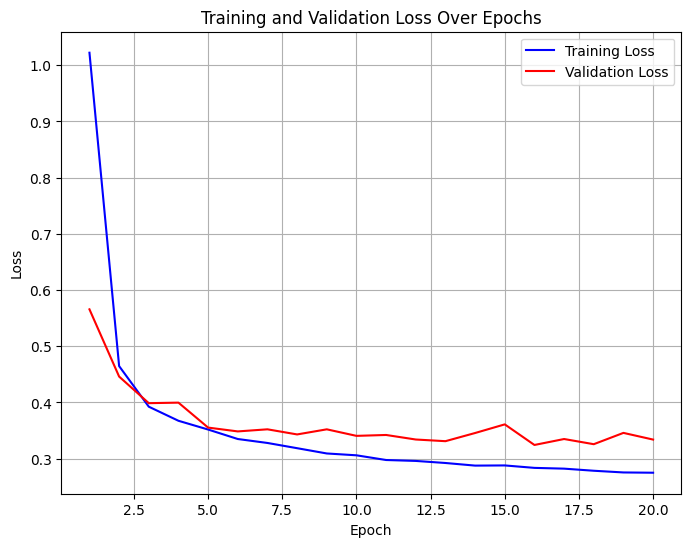

In [25]:
plot_losses(training_losses, validation_losses, label_one="Training", label_two="Validation")

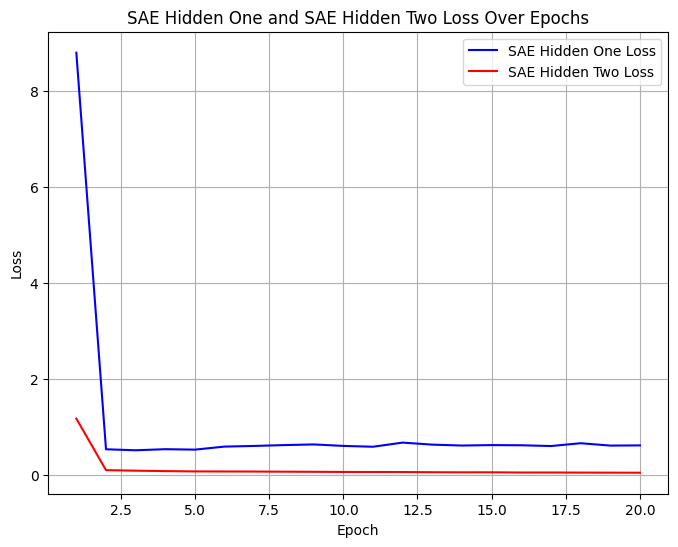

In [26]:
plot_losses(SAE_hidden_one_losses, SAE_hidden_two_losses, 
            label_one="SAE Hidden One", label_two="SAE Hidden Two")

## Eval

Evaluating our classification model accuracy, in addition to the reconstruction and sparisty metrics of each SAE.

In [27]:
best_model.eval()  # again currently a no-op
best_sae_one.eval()
best_sae_two.eval()

test_correct = 0
test_total = 0

feature_activations_one_test = torch.zeros(HIDDEN_SIZE, len(test_images))
feature_activations_two_test = torch.zeros(HIDDEN_SIZE, len(test_images))
labels_test = torch.zeros(len(test_images), dtype=torch.long)

recon_errors_one = []
recon_errors_two = []

with torch.no_grad():
    test_bar = tqdm(test_loader, desc=f"Evaluation")
    for i, batch in enumerate(test_bar):
        images, labels = batch
        images, labels = images.to(device), labels.to(device)

        # forward pass
        classification_out, hidden_one_act, hidden_two_act = best_model(images)
        reconstructed_one, encoded_one = best_sae_one(hidden_one_act)
        reconstructed_two, encoded_two = best_sae_two(hidden_two_act)

        # SAE reconstruction
        recon_errors_one.append(torch.mean((hidden_one_act - reconstructed_one) ** 2).item())
        recon_errors_two.append(torch.mean((hidden_two_act - reconstructed_two) ** 2).item())

        start_idx = i * test_loader.batch_size
        end_idx = start_idx + images.size(0)
        feature_activations_one_test[:, start_idx:end_idx] = encoded_one.T.cpu()
        feature_activations_two_test[:, start_idx:end_idx] = encoded_two.T.cpu()
        labels_test[start_idx:end_idx] = labels.cpu()

        # stats
        _, predicted = torch.max(classification_out, 1)
        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)

Z_test_one = feature_activations_one_test.T.numpy()
Z_test_two = feature_activations_two_test.T.numpy()
y_test = labels_test.numpy()

test_accuracy = 100 * test_correct / test_total
print(f"Final Test Accuracy: {test_accuracy:.2f}%")

# reconstruction accuracy of SAE at each layer
avg_recon_error_one = np.mean(recon_errors_one)
avg_recon_error_two = np.mean(recon_errors_two)
print(f"Average Reconstruction Error (Hidden One): {avg_recon_error_one:.4f}")
print(f"Average Reconstruction Error (Hidden Two): {avg_recon_error_two:.4f}")

# Compute sparsity (average non-zero features per image)
sparsity_one = torch.mean((feature_activations_one_test > 1e-5).float()).item() * 64
sparsity_two = torch.mean((feature_activations_two_test > 1e-5).float()).item() * 64
print(f"Average Non-Zero Features per Image (Hidden One): {sparsity_one:.2f}")
print(f"Average Non-Zero Features per Image (Hidden Two): {sparsity_two:.2f}")

Evaluation: 100%|██████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 311.14it/s]

Final Test Accuracy: 91.11%
Average Reconstruction Error (Hidden One): 0.1686
Average Reconstruction Error (Hidden Two): 0.0237
Average Non-Zero Features per Image (Hidden One): 32.81
Average Non-Zero Features per Image (Hidden Two): 33.70


# Reconstruction Testing

Making sure our SAE is actually good at creating reconstructions for downstream classification with test data.

In [33]:
best_model.eval()  # again currently a no-op
best_sae_one.eval()
best_sae_two.eval()

test_correct = 0
test_correct_two = 0
test_total = 0

with torch.no_grad():
    test_bar = tqdm(test_loader, desc=f"Evaluation")
    for i, batch in enumerate(test_bar):
        images, labels = batch
        images, labels = images.to(device), labels.to(device)

        # forward pass
        _, hidden_one_act, hidden_two_act = best_model(images)

        hidden_act_one_detached = hidden_one_act.detach()
        hidden_act_two_detached = hidden_two_act.detach()

        reconstructed_one, _ = best_sae_one(hidden_act_one_detached)
        reconstructed_two, _ = best_sae_two(hidden_act_two_detached)

        classification_out, _, _ = best_model(images, hidden_one_act=reconstructed_one)
        classification_out_two, _, _ = best_model(images, hidden_one_act=hidden_act_one_detached, hidden_two_act=reconstructed_two)

        # stats
        _, predicted = torch.max(classification_out, 1)
        test_correct += (predicted == labels).sum().item()
        
        _, predicted_two = torch.max(classification_out_two, 1)
        test_correct_two += (predicted_two == labels).sum().item()
        
        test_total += labels.size(0)

test_accuracy = 100 * test_correct / test_total
test_accuracy_two = 100 * test_correct_two / test_total
print(f"Final Test Accuracy (from recon 1): {test_accuracy:.2f}%")
print(f"Final Test Accuracy (from recon 2): {test_accuracy_two:.2f}%")

Evaluation: 100%|██████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 305.55it/s]

Final Test Accuracy (from recon 1): 91.10%
Final Test Accuracy (from recon 2): 91.07%


So, I think we must have had a bug at the end of our Cluster Ctd PT 2 notebook. Let's re-evaluate our 7 work there.

# RE-Eval of 7

In [96]:
hidden_activations_one = []
hidden_activations_two = []

sparse_act_one = []
sparse_act_two = []

labels = []

with torch.no_grad():
    for i in range(len(test_labels)):
        image = torch.from_numpy(test_images[i]).float().unsqueeze(0).to(device)
        label = test_labels[i]

        # Forward pass
        classification_out, hidden_one_act, hidden_two_act = best_model(image)

        hidden_act_one_detached = hidden_one_act.detach()
        hidden_act_two_detached = hidden_two_act.detach()
        
        _, encoding = best_sae_one(hidden_act_one_detached)
        _, encoding_two = best_sae_two(hidden_act_two_detached)
        
        # Get predicted class
        hidden_activations_one.append(hidden_act_one_detached.cpu().numpy().flatten())
        hidden_activations_two.append(hidden_act_two_detached.cpu().numpy().flatten())

        sparse_act_one.append(encoding.cpu().numpy().flatten())
        sparse_act_two.append(encoded_two.cpu().numpy().flatten())

        labels.append(label)

hidden_activations_one = np.array(hidden_activations_one)
hidden_activations_two = np.array(hidden_activations_two)

sparse_act_one = np.array(sparse_act_one)
sparse_act_two = np.array(sparse_act_two)

labels = np.array(labels)

## Reconstruction Examination on 7s

### Full Enocoded Vector

In [58]:
num_7s = 0
correctly_identified_full = 0
falsely_identified_full = {}

for i, label in enumerate(test_labels):
    if label == 7:
        num_7s += 1

        image = torch.from_numpy(test_images[i]).float().unsqueeze(0).to(device)
        
        encoded = sparse_act_one[i].copy()
        encoded_digit_torch = torch.from_numpy(encoded).float().to(device).unsqueeze(0)

        with torch.no_grad():
            recon = best_sae_one.decoder(encoded_digit_torch)
            recon = recon.view(1, -1)
        
            classification_out, _, _ = best_model(image, hidden_one_act=recon)
        
            probs = torch.softmax(classification_out, dim=1)
            _, pred = torch.max(classification_out, 1)

            if label == pred.item():
                correctly_identified_full += 1
            else:
                falsely_identified_full[i] = pred.item()

print(f"The number of correctly identified 7s: {correctly_identified_full}")
print(f"The number of incorrectly identified 7s: {len(falsely_identified_full)}")
print(f"Percentage correct: {round(correctly_identified_full / num_7s * 100, 3)}%")

The number of correctly identified 7s: 947
The number of incorrectly identified 7s: 81
Percentage correct: 92.121%


### Features 78 and 121

In [63]:
num_7s = 0
correctly_identified_full = 0
falsely_identified_full = {}

for i, label in enumerate(test_labels):
    if label == 7:
        num_7s += 1

        image = torch.from_numpy(test_images[i]).float().unsqueeze(0).to(device)
        
        sparse_vector = sparse_act_one[i].copy()
        
        encoded = np.zeros(HIDDEN_SIZE)
        encoded[78] = sparse_vector[78]
        encoded[121] = sparse_vector[121]
        encoded_digit_torch = torch.from_numpy(encoded).float().to(device).unsqueeze(0)

        with torch.no_grad():
            recon = best_sae_one.decoder(encoded_digit_torch)
            recon = recon.view(1, -1)
        
            classification_out, _, _ = best_model(image, hidden_one_act=recon)
        
            probs = torch.softmax(classification_out, dim=1)
            _, pred = torch.max(classification_out, 1)

            if label == pred.item():
                correctly_identified_full += 1
            else:
                falsely_identified_full[i] = pred.item()

print(f"The number of correctly identified 7s: {correctly_identified_full}")
print(f"The number of incorrectly identified 7s: {len(falsely_identified_full)}")
print(f"Percentage correct: {round(correctly_identified_full / num_7s * 100, 3)}%")

The number of correctly identified 7s: 722
The number of incorrectly identified 7s: 306
Percentage correct: 70.233%


In [75]:
num_7s = 0
correctly_identified_full = 0
falsely_identified_full = {}

for i, label in enumerate(test_labels):
    if label == 7:
        num_7s += 1

        image = torch.from_numpy(test_images[i]).float().unsqueeze(0).to(device)
        
        sparse_vector = sparse_act_one[i].copy()
        
        encoded = sparse_vector
        encoded[78] = 0
        encoded[121] = 0
        encoded_digit_torch = torch.from_numpy(encoded).float().to(device).unsqueeze(0)

        with torch.no_grad():
            recon = best_sae_one.decoder(encoded_digit_torch)
            recon = recon.view(1, -1)
        
            classification_out, _, _ = best_model(image, hidden_one_act=recon)
        
            probs = torch.softmax(classification_out, dim=1)
            _, pred = torch.max(classification_out, 1)

            if label == pred.item():
                correctly_identified_full += 1
            else:
                falsely_identified_full[i] = pred.item()

print(f"The number of correctly identified 7s: {correctly_identified_full}")
print(f"The number of incorrectly identified 7s: {len(falsely_identified_full)}")
print(f"Percentage correct: {round(correctly_identified_full / num_7s * 100, 3)}%")

The number of correctly identified 7s: 941
The number of incorrectly identified 7s: 87
Percentage correct: 91.537%


### Features 15, 85, 150 and 227

In [71]:
num_7s = 0
correctly_identified_full = 0
falsely_identified_full = {}

for i, label in enumerate(test_labels):
    if label == 7:
        num_7s += 1

        image = torch.from_numpy(test_images[i]).float().unsqueeze(0).to(device)
        
        sparse_vector = sparse_act_one[i].copy()
        
        encoded = np.zeros(HIDDEN_SIZE)
        encoded[85] = sparse_vector[85]
        encoded[150] = sparse_vector[150]
        encoded[227] = sparse_vector[227]
        encoded_digit_torch = torch.from_numpy(encoded).float().to(device).unsqueeze(0)

        with torch.no_grad():
            recon = best_sae_one.decoder(encoded_digit_torch)
            recon = recon.view(1, -1)
        
            classification_out, _, _ = best_model(image, hidden_one_act=recon)
        
            probs = torch.softmax(classification_out, dim=1)
            _, pred = torch.max(classification_out, 1)

            if label == pred.item():
                correctly_identified_full += 1
            else:
                falsely_identified_full[i] = pred.item()

print(f"The number of correctly identified 7s: {correctly_identified_full}")
print(f"The number of incorrectly identified 7s: {len(falsely_identified_full)}")
print(f"Percentage correct: {round(correctly_identified_full / num_7s * 100, 3)}%")

The number of correctly identified 7s: 0
The number of incorrectly identified 7s: 1028
Percentage correct: 0.0%


In [66]:
num_7s = 0
correctly_identified_full = 0
falsely_identified_full = {}

for i, label in enumerate(test_labels):
    if label == 7:
        num_7s += 1

        image = torch.from_numpy(test_images[i]).float().unsqueeze(0).to(device)
        
        sparse_vector = sparse_act_one[i].copy()
        
        encoded = np.zeros(HIDDEN_SIZE)
        encoded[85] = sparse_vector[85]
        encoded[150] = sparse_vector[150]
        encoded[227] = sparse_vector[227]
        encoded[15] = sparse_vector[15]
        encoded_digit_torch = torch.from_numpy(encoded).float().to(device).unsqueeze(0)

        with torch.no_grad():
            recon = best_sae_one.decoder(encoded_digit_torch)
            recon = recon.view(1, -1)
        
            classification_out, _, _ = best_model(image, hidden_one_act=recon)
        
            probs = torch.softmax(classification_out, dim=1)
            _, pred = torch.max(classification_out, 1)

            if label == pred.item():
                correctly_identified_full += 1
            else:
                falsely_identified_full[i] = pred.item()

print(f"The number of correctly identified 7s: {correctly_identified_full}")
print(f"The number of incorrectly identified 7s: {len(falsely_identified_full)}")
print(f"Percentage correct: {round(correctly_identified_full / num_7s * 100, 3)}%")

The number of correctly identified 7s: 730
The number of incorrectly identified 7s: 298
Percentage correct: 71.012%


In [61]:
num_7s = 0
correctly_identified_full = 0
falsely_identified_full = {}

for i, label in enumerate(test_labels):
    if label == 7:
        num_7s += 1

        image = torch.from_numpy(test_images[i]).float().unsqueeze(0).to(device)
        
        sparse_vector = sparse_act_one[i].copy()
        encoded = sparse_vector
        encoded[85] = 0
        encoded[150] = 0
        encoded[227] = 0
        encoded[15] = 0
        encoded_digit_torch = torch.from_numpy(encoded).float().to(device).unsqueeze(0)

        with torch.no_grad():
            recon = best_sae_one.decoder(encoded_digit_torch)
            recon = recon.view(1, -1)
        
            classification_out, _, _ = best_model(image, hidden_one_act=recon)
        
            probs = torch.softmax(classification_out, dim=1)
            _, pred = torch.max(classification_out, 1)

            if label == pred.item():
                correctly_identified_full += 1
            else:
                falsely_identified_full[i] = pred.item()

print(f"The number of correctly identified 7s: {correctly_identified_full}")
print(f"The number of incorrectly identified 7s: {len(falsely_identified_full)}")
print(f"Percentage correct: {round(correctly_identified_full / num_7s * 100, 3)}%")

The number of correctly identified 7s: 933
The number of incorrectly identified 7s: 95
Percentage correct: 90.759%


### No Features

In [62]:
num_7s = 0
correctly_identified_full = 0
falsely_identified_full = {}

for i, label in enumerate(test_labels):
    if label == 7:
        num_7s += 1

        image = torch.from_numpy(test_images[i]).float().unsqueeze(0).to(device)
        
        encoded = np.zeros(HIDDEN_SIZE)
        encoded_digit_torch = torch.from_numpy(encoded).float().to(device).unsqueeze(0)

        with torch.no_grad():
            recon = best_sae_one.decoder(encoded_digit_torch)
            recon = recon.view(1, -1)
        
            classification_out, _, _ = best_model(image, hidden_one_act=recon)
        
            probs = torch.softmax(classification_out, dim=1)
            _, pred = torch.max(classification_out, 1)

            if label == pred.item():
                correctly_identified_full += 1
            else:
                falsely_identified_full[i] = pred.item()

print(f"The number of correctly identified 7s: {correctly_identified_full}")
print(f"The number of incorrectly identified 7s: {len(falsely_identified_full)}")
print(f"Percentage correct: {round(correctly_identified_full / num_7s * 100, 3)}%")

The number of correctly identified 7s: 0
The number of incorrectly identified 7s: 1028
Percentage correct: 0.0%


### Best Sparse Vector?

In [76]:
num_7s = 0
correctly_identified_full = 0
falsely_identified_full = {}

for i, label in enumerate(test_labels):
    if label == 7:
        num_7s += 1

        image = torch.from_numpy(test_images[i]).float().unsqueeze(0).to(device)
        
        sparse_vector = sparse_act_one[i].copy()

        encoded = np.zeros(HIDDEN_SIZE)
        encoded[15] = sparse_vector[15]
        encoded[78] = sparse_vector[78]
        encoded[121] = sparse_vector[121]
        encoded_digit_torch = torch.from_numpy(encoded).float().to(device).unsqueeze(0)

        with torch.no_grad():
            recon = best_sae_one.decoder(encoded_digit_torch)
            recon = recon.view(1, -1)
        
            classification_out, _, _ = best_model(image, hidden_one_act=recon)
        
            probs = torch.softmax(classification_out, dim=1)
            _, pred = torch.max(classification_out, 1)

            if label == pred.item():
                correctly_identified_full += 1
            else:
                falsely_identified_full[i] = pred.item()

print(f"The number of correctly identified 7s: {correctly_identified_full}")
print(f"The number of incorrectly identified 7s: {len(falsely_identified_full)}")
print(f"Percentage correct: {round(correctly_identified_full / num_7s * 100, 3)}%")

The number of correctly identified 7s: 905
The number of incorrectly identified 7s: 123
Percentage correct: 88.035%


In [99]:
num_7s = 0
correctly_identified_full = 0
falsely_identified_full = {}

for i, label in enumerate(test_labels):
    if label == 7:
        num_7s += 1

        image = torch.from_numpy(test_images[i]).float().unsqueeze(0).to(device)
        
        sparse_vector = sparse_act_one[i].copy()

        encoded = np.zeros(HIDDEN_SIZE)
        encoded_digit_torch = torch.from_numpy(encoded).float().to(device).unsqueeze(0)

        with torch.no_grad():
            recon = best_sae_one.decoder(encoded_digit_torch)
            recon = recon.view(1, -1)
        
            classification_out, _, _ = best_model(image, hidden_one_act=recon)
        
            probs = torch.softmax(classification_out, dim=1)
            _, pred = torch.max(classification_out, 1)

            if label == pred.item():
                correctly_identified_full += 1
            else:
                falsely_identified_full[i] = pred.item()

print(f"The number of correctly identified 7s: {correctly_identified_full}")
print(f"The number of incorrectly identified 7s: {len(falsely_identified_full)}")
print(f"Percentage correct: {round(correctly_identified_full / num_7s * 100, 3)}%")

The number of correctly identified 7s: 0
The number of incorrectly identified 7s: 1028
Percentage correct: 0.0%


I think it's safe to say our work from previous experiments holds, for the most part. Features 15, 78 and 121 are definitely important when it comes to identifying the digit 7. Ablating them yields 0% accuracy. Turning only those 3 on yields 88% accruacy, whereas all sparse features being on would yield 92%.

# Feature Exploration Across Classes

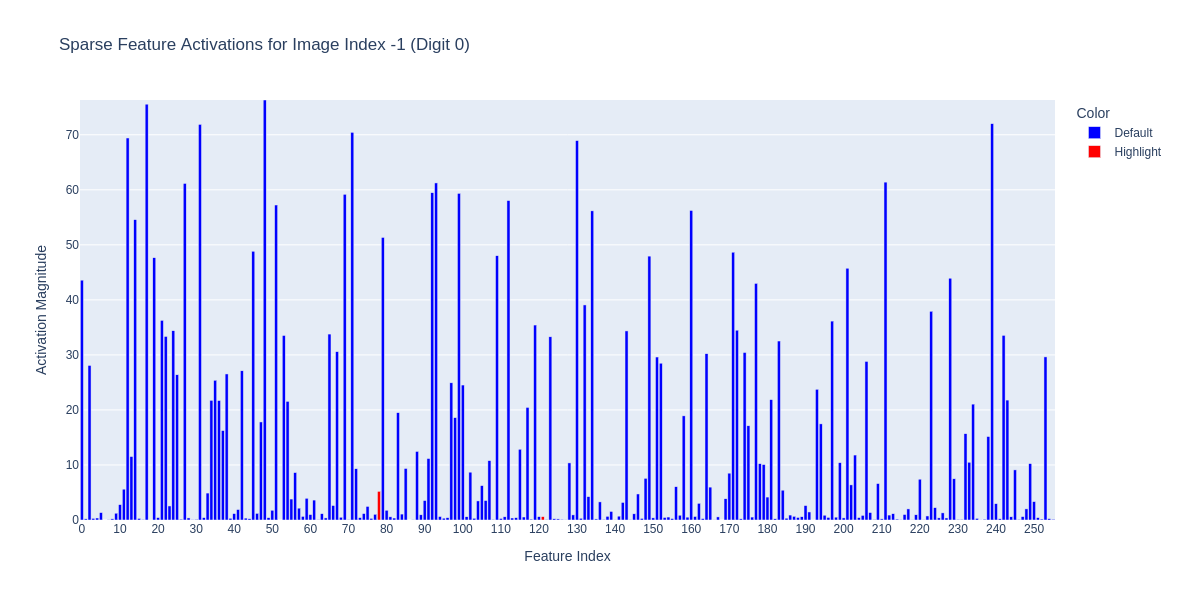

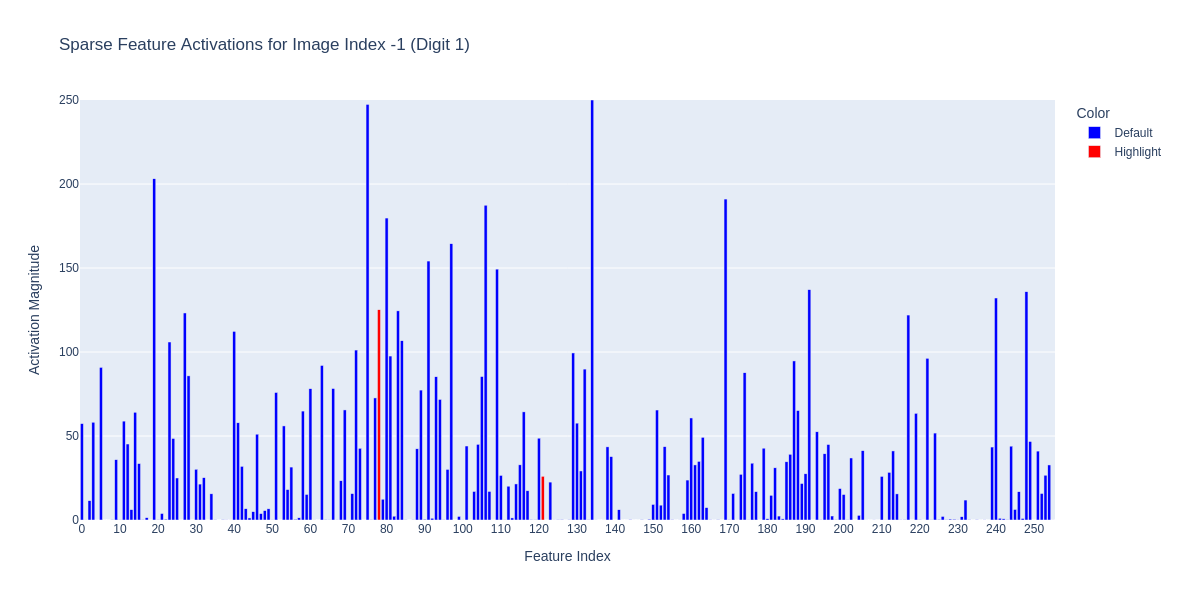

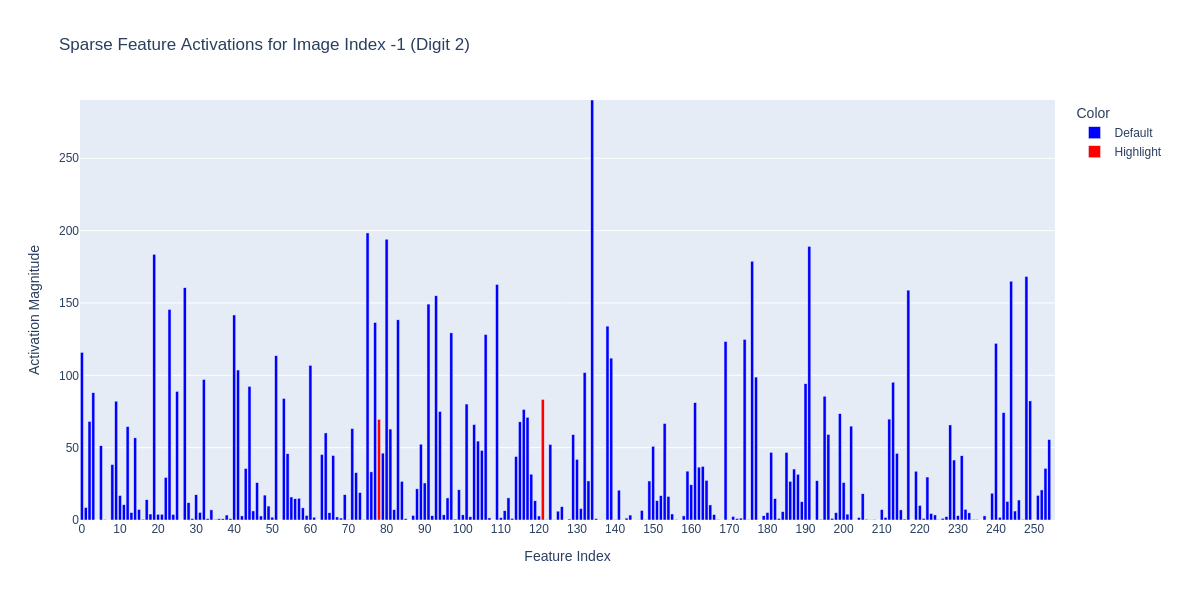

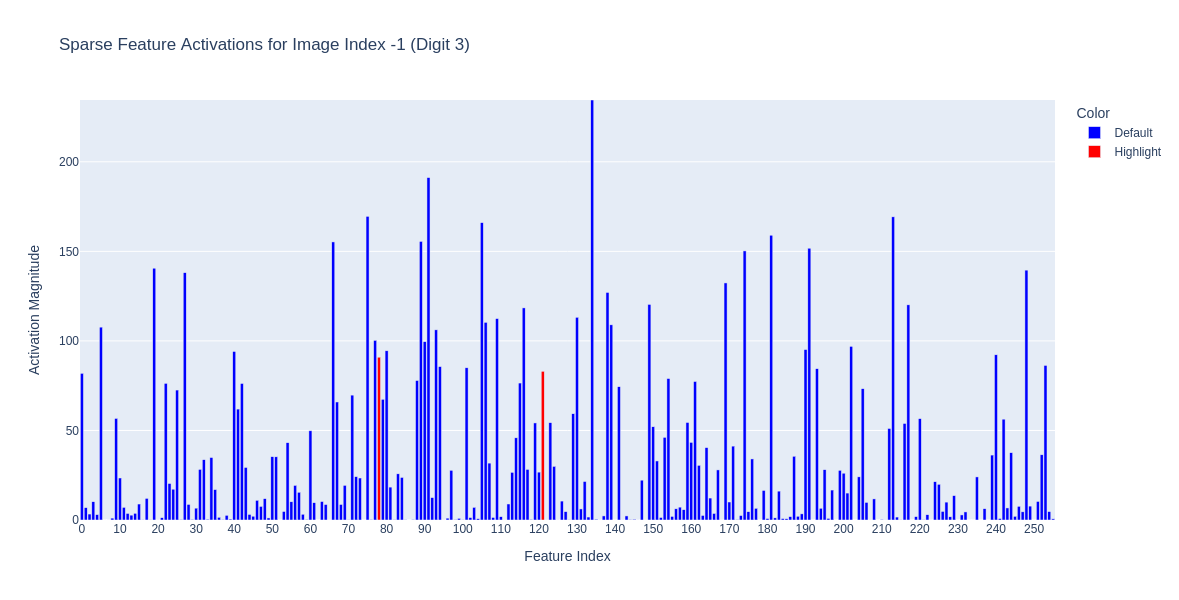

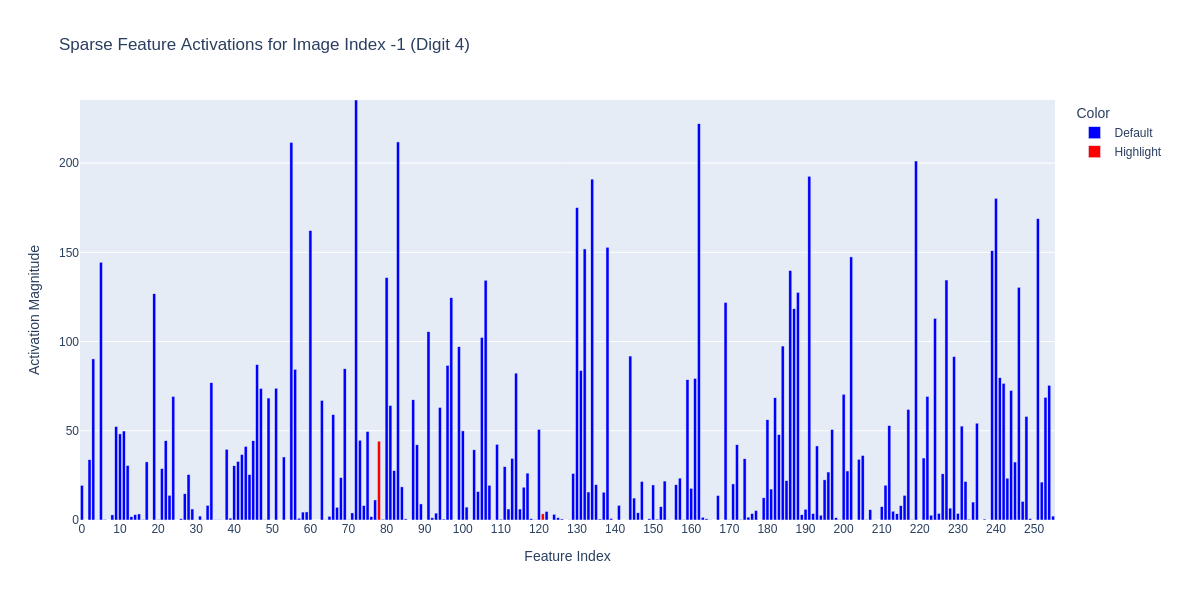

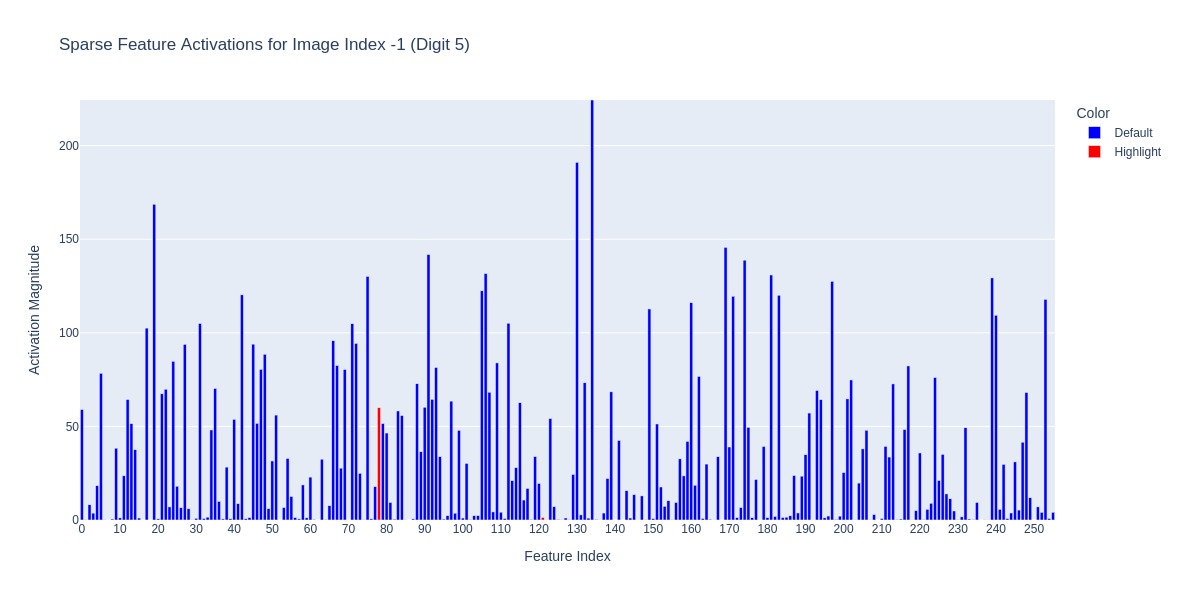

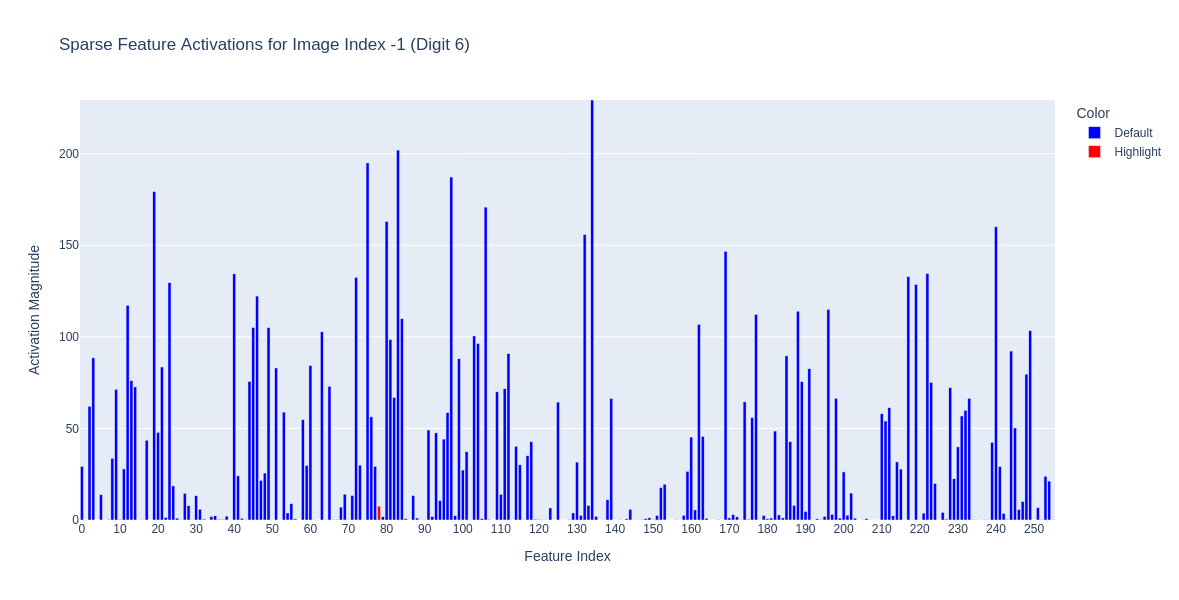

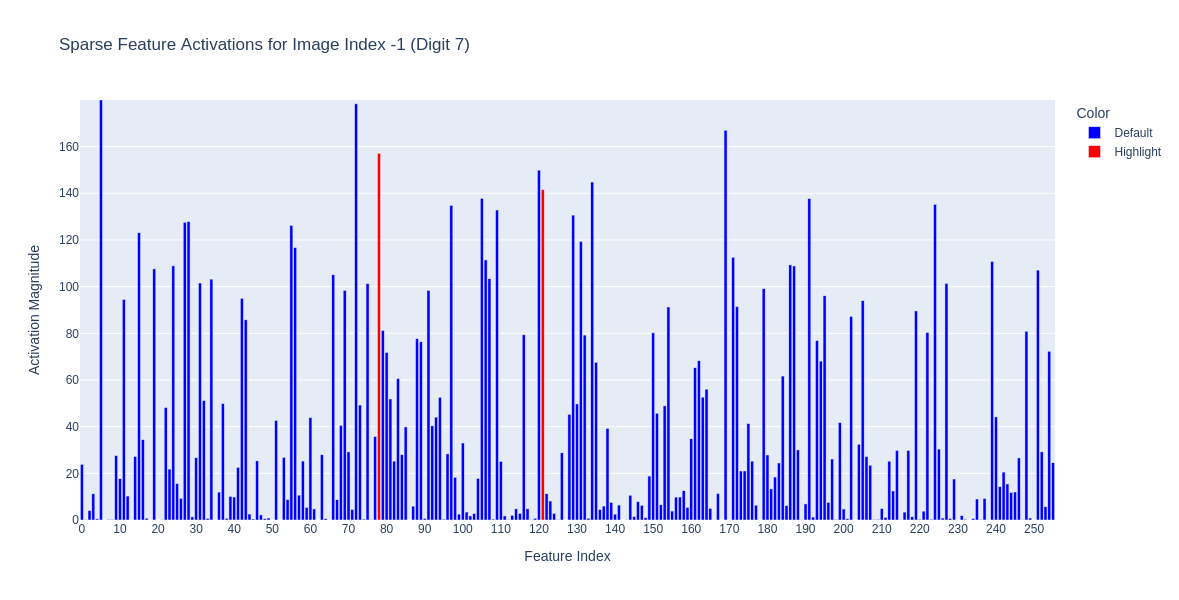

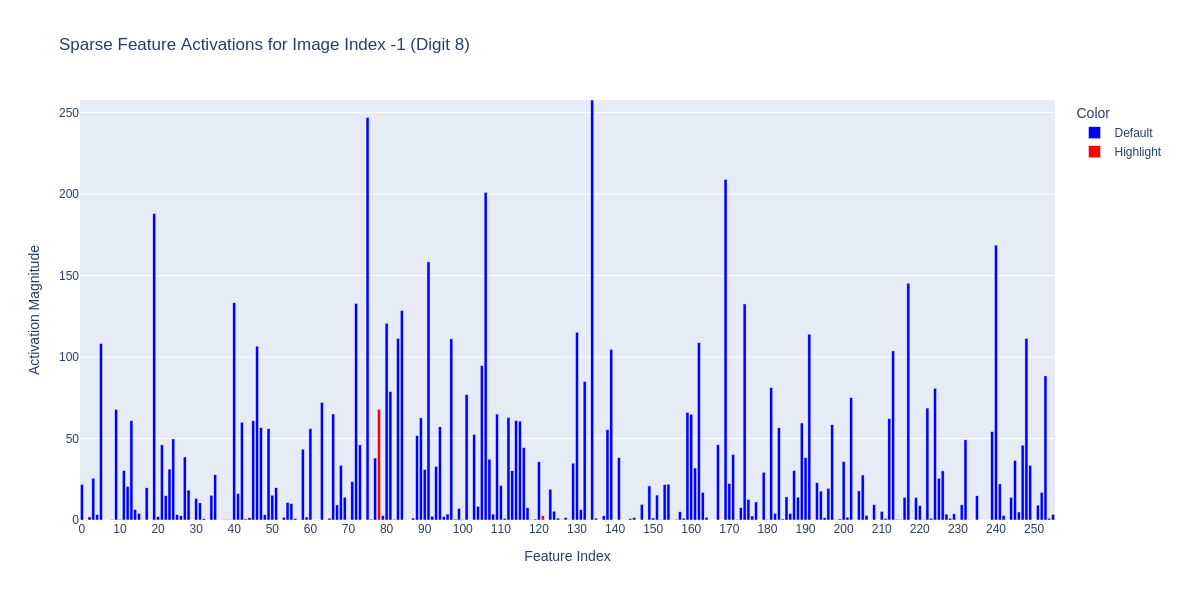

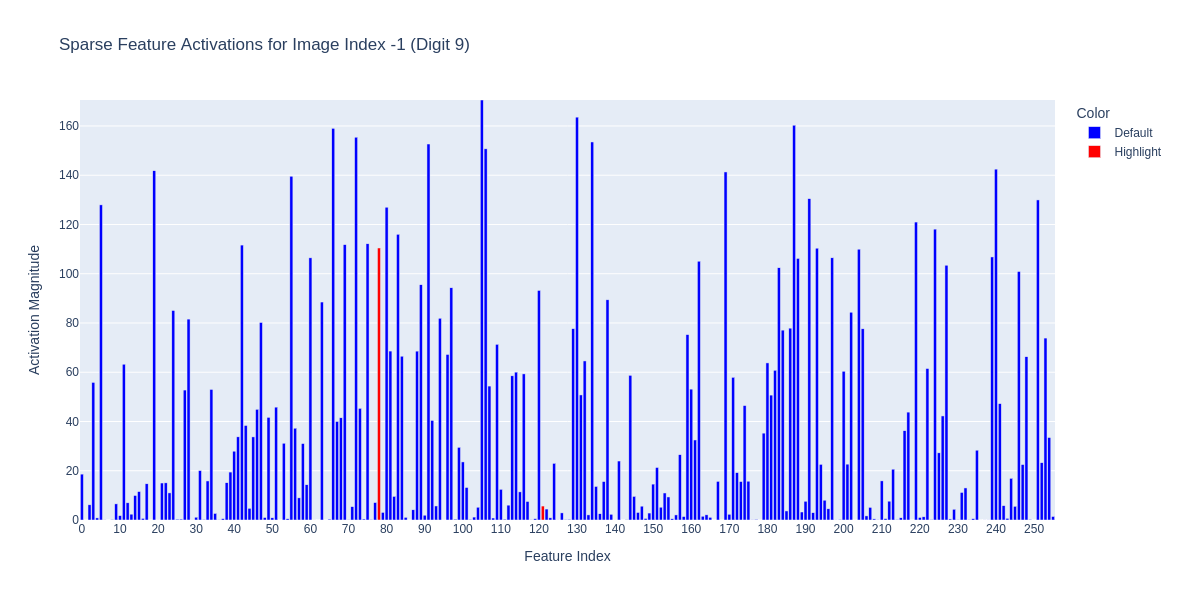

In [192]:
avg_digit_encoding = {}
top_n_features = {}
N = 8

for digit in range(10):
    mask = labels == digit
    mean_digit_encoding = np.mean(sparse_act_one[mask], axis=0)
    avg_digit_encoding[digit] = mean_digit_encoding

    top_n_indices = np.argsort(mean_digit_encoding)[-N:][::-1]  # Sort descending
    top_n_values = mean_digit_encoding[top_n_indices]

    top_n_features[digit] = {
        'indices': top_n_indices.tolist(),
        'activations': top_n_values.tolist()
    }

    plot_sparse_features(mean_digit_encoding, -1, digit, HIDDEN_SIZE)

In [193]:
for digit in range(10):
    print(f"\nDigit {digit}:")
    print(f"Top {N} feature indices: {top_n_features[digit]['indices']}")
    print(f"Top {N} activation values: {[round(x, 3) for x in top_n_features[digit]['activations']]}")


Digit 0:
Top 8 feature indices: [48, 17, 239, 31, 71, 12, 130, 211]
Top 8 activation values: [76.321, 75.565, 72.021, 71.894, 70.454, 69.418, 68.945, 61.399]

Digit 1:
Top 8 feature indices: [134, 75, 19, 169, 106, 80, 97, 91]
Top 8 activation values: [250.029, 247.439, 203.154, 191.064, 187.403, 179.756, 164.47, 154.155]

Digit 2:
Top 8 feature indices: [134, 75, 80, 191, 19, 176, 248, 244]
Top 8 activation values: [290.277, 198.394, 194.083, 189.149, 183.67, 178.862, 168.357, 165.043]

Digit 3:
Top 8 feature indices: [134, 91, 75, 213, 105, 181, 89, 66]
Top 8 activation values: [234.512, 191.199, 169.574, 169.27, 166.034, 159.023, 155.575, 155.263]

Digit 4:
Top 8 feature indices: [72, 162, 83, 55, 219, 191, 134, 240]
Top 8 activation values: [235.362, 222.068, 211.848, 211.603, 201.177, 192.646, 191.038, 180.276]

Digit 5:
Top 8 feature indices: [134, 130, 19, 169, 91, 174, 106, 181]
Top 8 activation values: [224.392, 191.088, 168.711, 145.691, 141.829, 138.82, 131.675, 130.904]

D

In [194]:
def get_unique_features(selected, top_n_features):
    other_features = []
    for digit in top_n_features:
        if digit != selected:
            other_features.extend(top_n_features[digit]["indices"])

    selected_features = top_n_features[selected]["indices"]

    unique_features = []
    for feature in selected_features:
        if feature not in other_features:
            unique_features.append(feature)

    return unique_features, set(other_features)

In [195]:
print(f"For top {N} features:")
for digit in range(10):
    selected_features, other_features = get_unique_features(digit, top_n_features)
    print(digit, selected_features, len(other_features))

For top 8 features:
0 [48, 17, 239, 31, 71, 12, 211] 31
1 [] 38
2 [176, 248, 244] 35
3 [213, 89] 36
4 [162, 55, 219] 35
5 [174] 37
6 [] 38
7 [5, 78, 120, 121] 34
8 [217] 37
9 [187] 37


Assuming we can represent each digit with a sparse vector consisting of 10 features, we'd only need 45/256 features in the sparse vector space...

In [196]:
top_n_features[5]

{'indices': [134, 130, 19, 169, 91, 174, 106, 181],
 'activations': [224.39178466796875,
  191.08815002441406,
  168.71136474609375,
  145.69137573242188,
  141.82861328125,
  138.8199920654297,
  131.67453002929688,
  130.90444946289062]}

### Partcular Digit

Assessing sparsity of 5:
The number of correctly identified 5s: 0
The number of incorrectly identified 5s: 892
Percentage correct: 0.0%


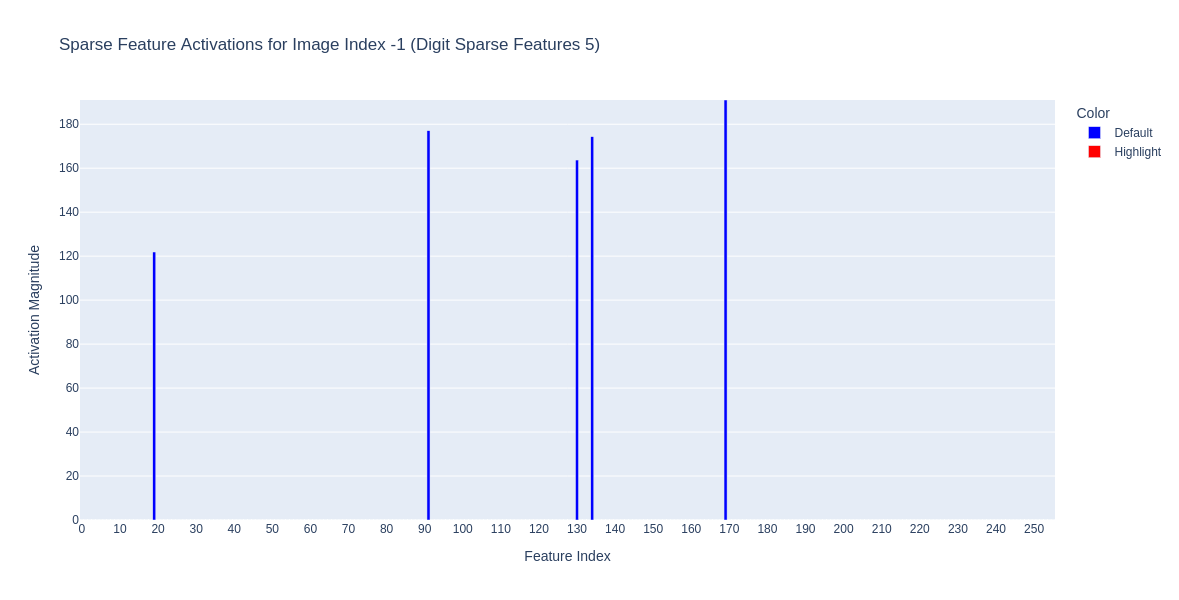

In [202]:
num_d = 0
correctly_identified = 0
falsely_identified = {}

feature_idx_one = 134
feature_idx_two = 130
feature_idx_three = 19
feature_idx_four = 169
feature_idx_five = 91

digit = 5
for i, label in enumerate(test_labels):
    if label == digit:
        num_d += 1

        image = torch.from_numpy(test_images[i]).float().unsqueeze(0).to(device)
        
        sparse_vector = sparse_act_one[i].copy()

        encoded = np.zeros(HIDDEN_SIZE)
        encoded[feature_idx_one] = sparse_vector[feature_idx_one]
        encoded[feature_idx_two] = sparse_vector[feature_idx_two]
        encoded[feature_idx_three] = sparse_vector[feature_idx_three]
        encoded[feature_idx_four] = sparse_vector[feature_idx_four]
        encoded[feature_idx_five] = sparse_vector[feature_idx_five]
        
        encoded_digit_torch = torch.from_numpy(encoded).float().to(device).unsqueeze(0)

        with torch.no_grad():
            recon = best_sae_one.decoder(encoded_digit_torch)
            recon = recon.view(1, -1)
        
            classification_out, _, _ = best_model(image, hidden_one_act=recon)
        
            probs = torch.softmax(classification_out, dim=1)
            _, pred = torch.max(classification_out, 1)

            if label == pred.item():
                correctly_identified += 1
            else:
                falsely_identified[i] = pred.item()

print(f"Assessing sparsity of {digit}:")
print(f"The number of correctly identified {digit}s: {correctly_identified}")
print(f"The number of incorrectly identified {digit}s: {len(falsely_identified)}")
print(f"Percentage correct: {round(correctly_identified / num_d * 100, 3)}%")

plot_sparse_features(encoded, -1, f"Sparse Features {digit}", HIDDEN_SIZE)

### All Digits

Assessing sparsity of 0:
The number of correctly identified 0s: 980
The number of incorrectly identified 0s: 0
Percentage correct: 100.0%


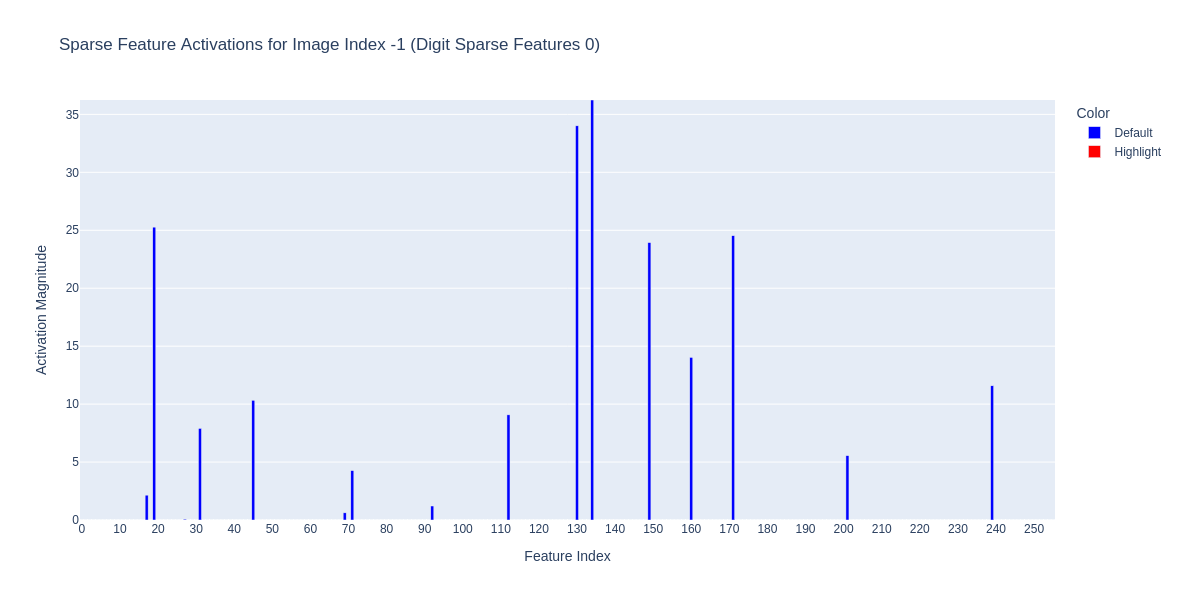

Assessing sparsity of 1:
The number of correctly identified 1s: 1127
The number of incorrectly identified 1s: 8
Percentage correct: 99.295%


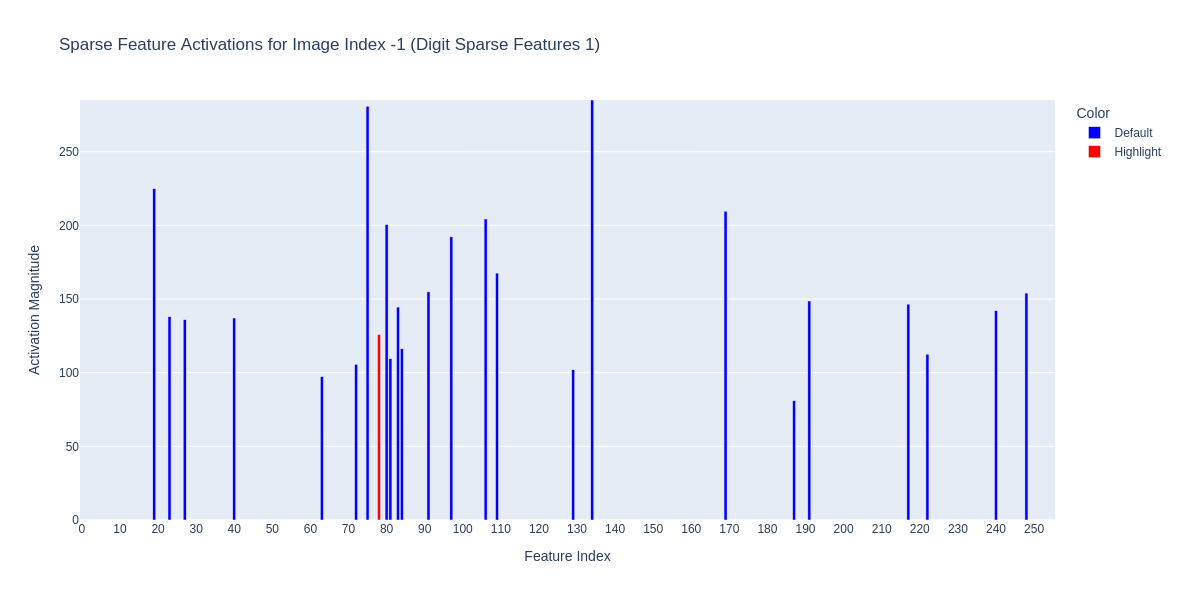

Assessing sparsity of 2:
The number of correctly identified 2s: 952
The number of incorrectly identified 2s: 80
Percentage correct: 92.248%


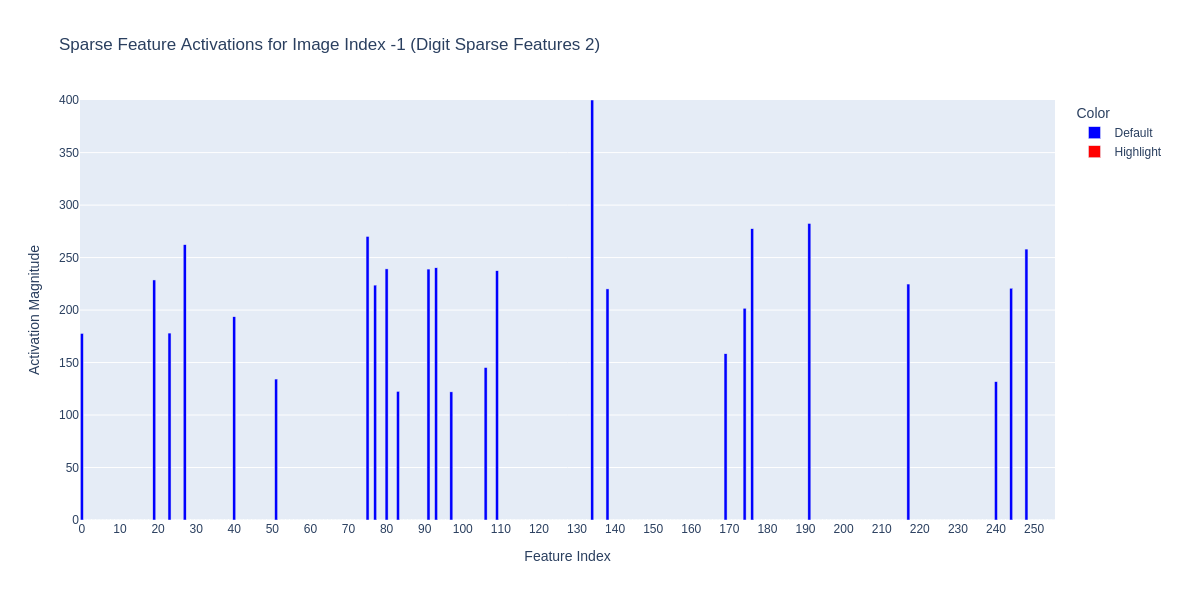

Assessing sparsity of 3:
The number of correctly identified 3s: 1000
The number of incorrectly identified 3s: 10
Percentage correct: 99.01%


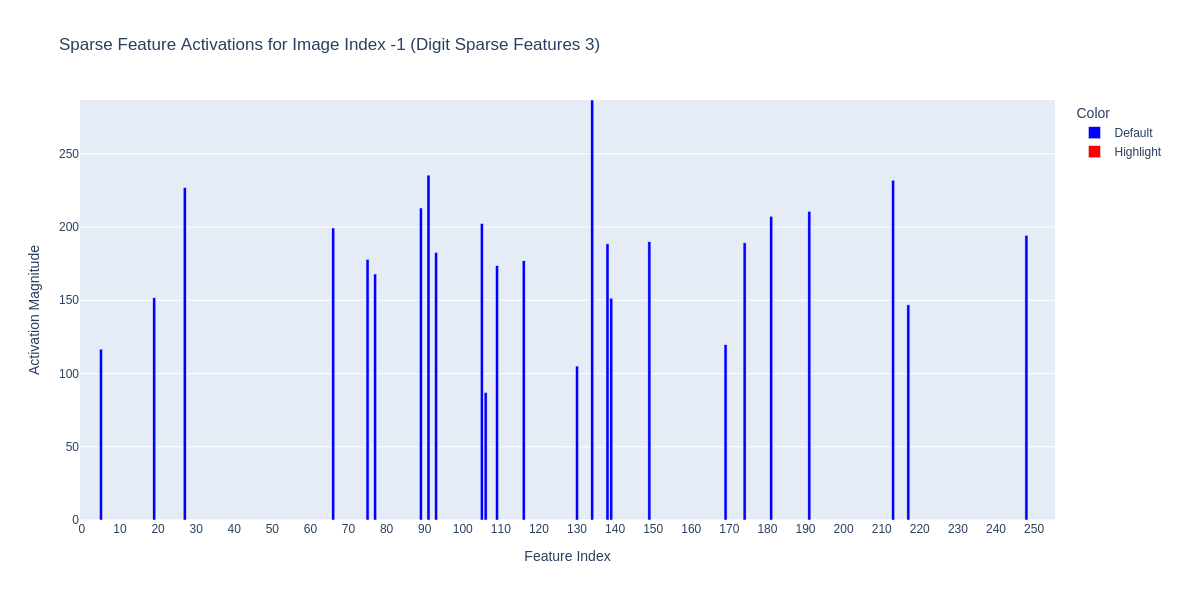

Assessing sparsity of 4:
The number of correctly identified 4s: 972
The number of incorrectly identified 4s: 10
Percentage correct: 98.982%


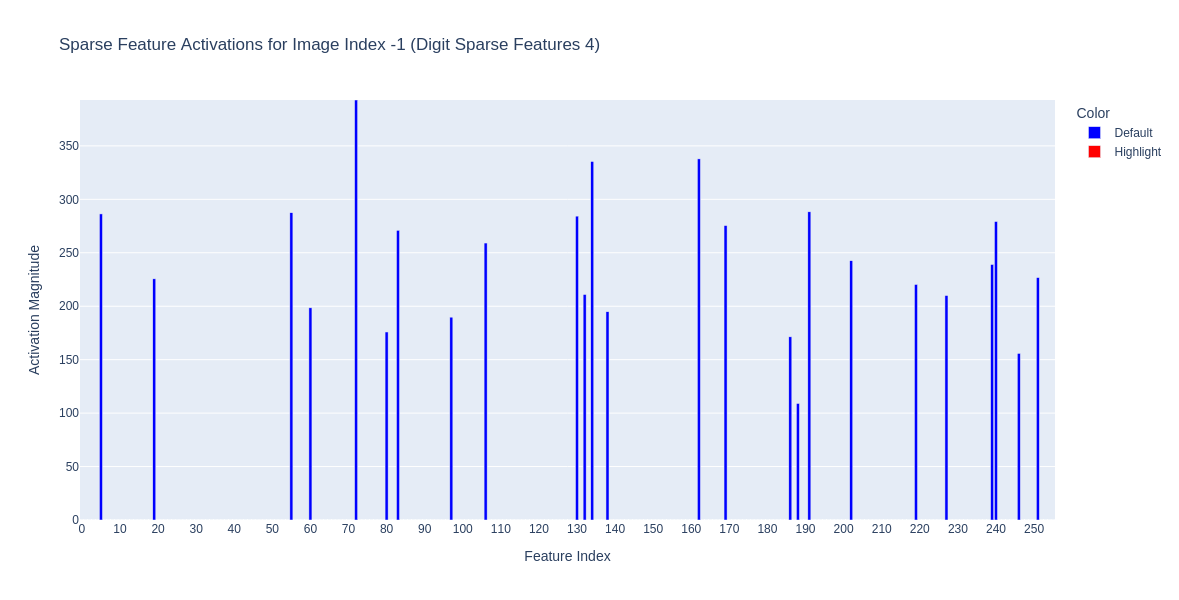

Assessing sparsity of 5:
The number of correctly identified 5s: 468
The number of incorrectly identified 5s: 424
Percentage correct: 52.466%


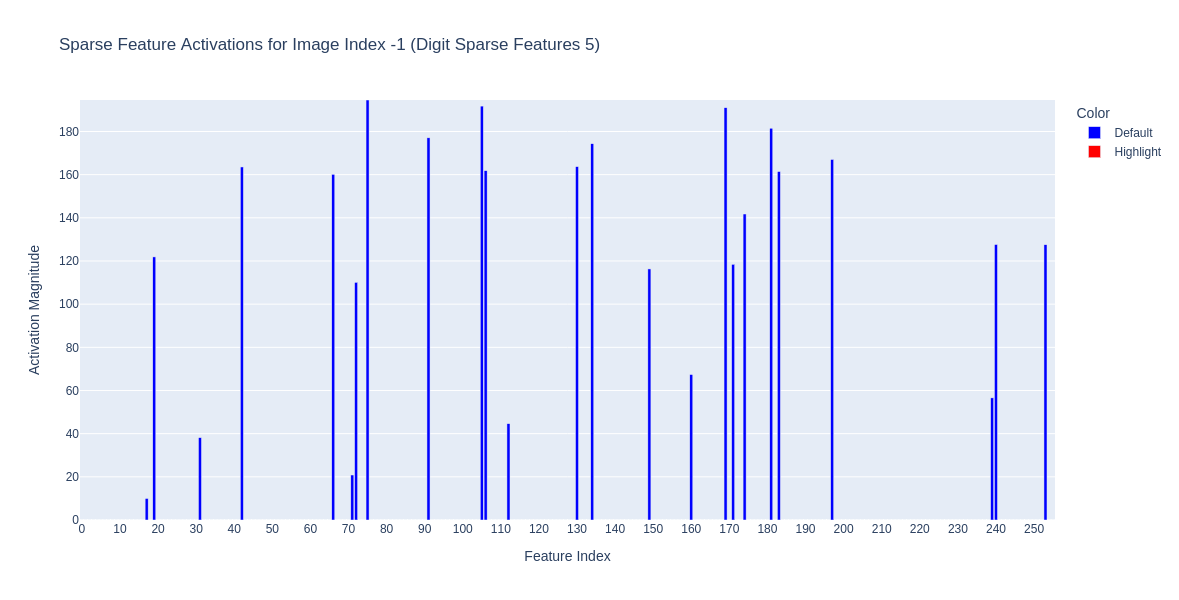

Assessing sparsity of 6:
The number of correctly identified 6s: 862
The number of incorrectly identified 6s: 96
Percentage correct: 89.979%


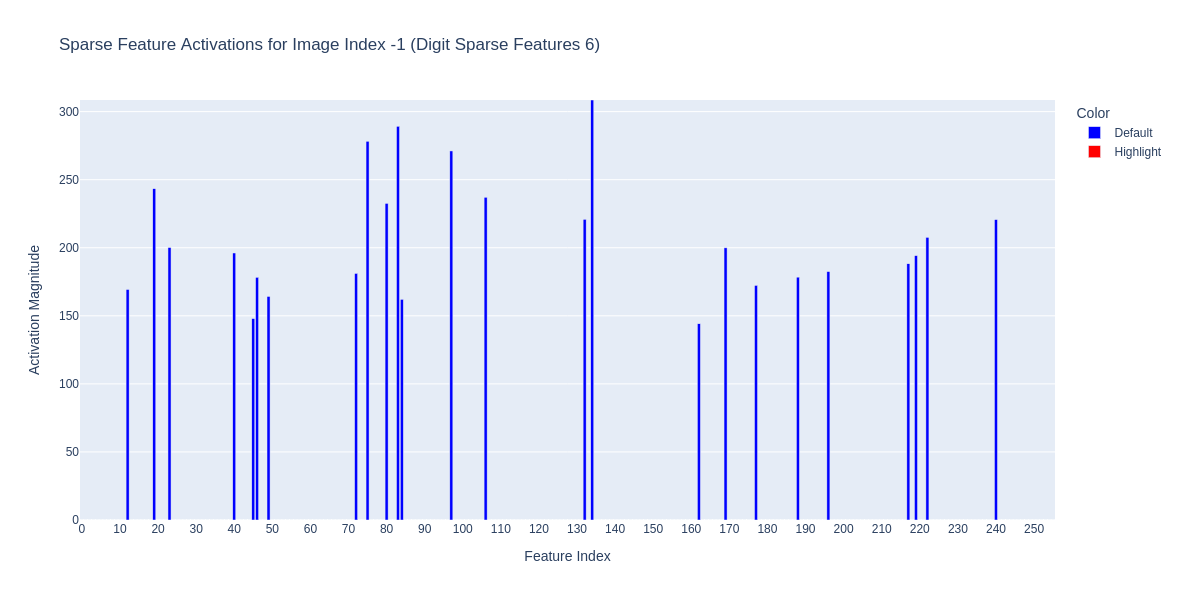

Assessing sparsity of 7:
The number of correctly identified 7s: 1019
The number of incorrectly identified 7s: 9
Percentage correct: 99.125%


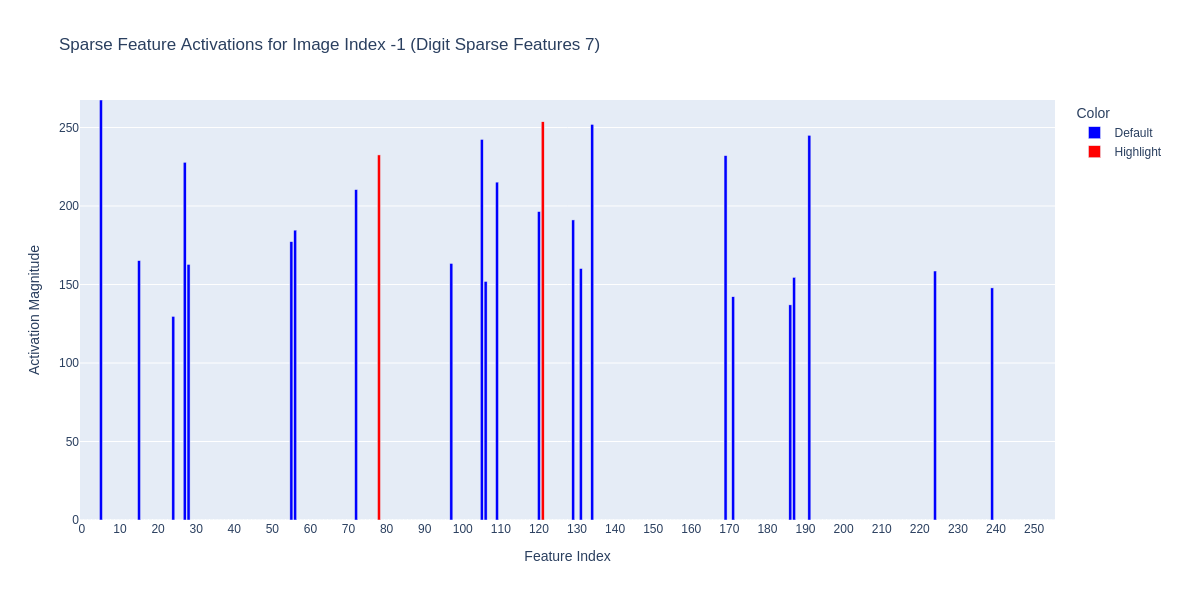

Assessing sparsity of 8:
The number of correctly identified 8s: 961
The number of incorrectly identified 8s: 13
Percentage correct: 98.665%


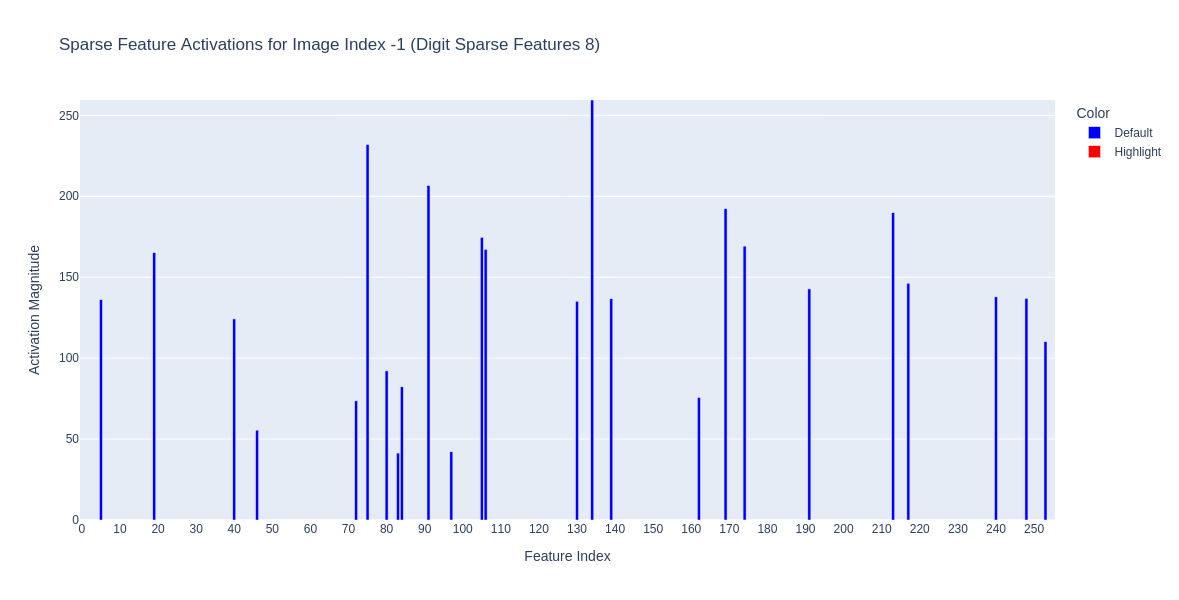

Assessing sparsity of 9:
The number of correctly identified 9s: 947
The number of incorrectly identified 9s: 62
Percentage correct: 93.855%


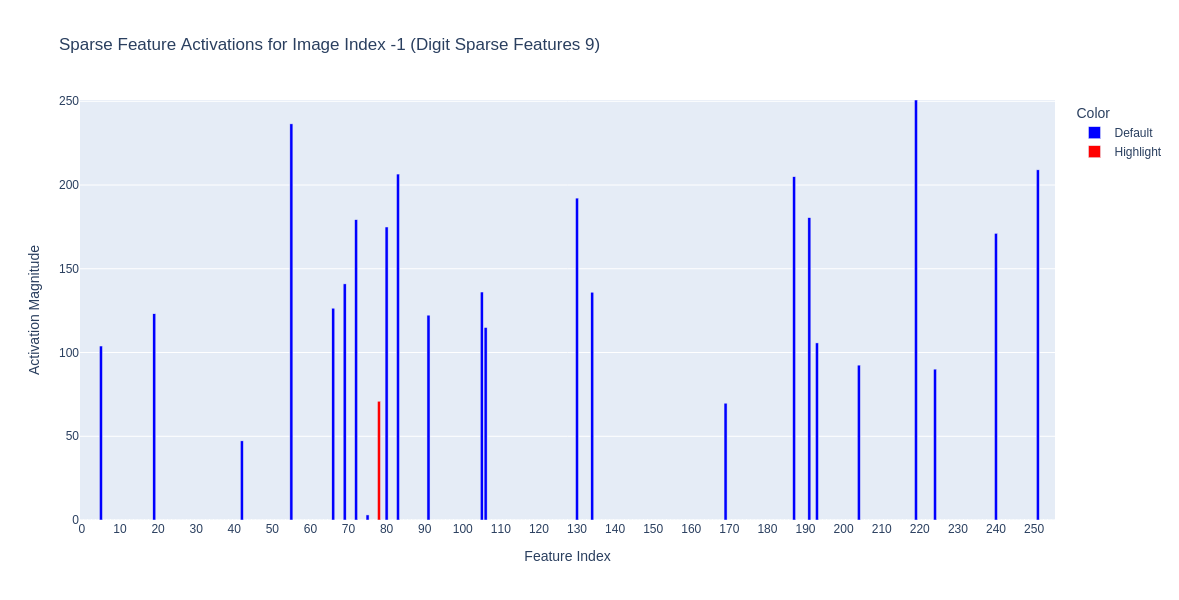

In [183]:
for digit in range(10):
    num_d = 0
    correctly_identified = 0
    falsely_identified = {}
    
    # feature_idx_one = 134
    # feature_idx_two = 75
    # feature_idx_three = 19
    # feature_idx_four = 81
    # feature_idx_five = 63

    for i, label in enumerate(test_labels):
        if label == digit:
            num_d += 1
    
            image = torch.from_numpy(test_images[i]).float().unsqueeze(0).to(device)
            
            sparse_vector = sparse_act_one[i].copy()
    
            encoded = np.zeros(HIDDEN_SIZE)
    
            for feature_idx in top_n_features[digit]["indices"]:
                encoded[feature_idx] = sparse_vector[feature_idx]
            # encoded[feature_idx_one] = sparse_vector[feature_idx_one]
            # encoded[feature_idx_two] = sparse_vector[feature_idx_two]
            # encoded[feature_idx_three] = sparse_vector[feature_idx_three]
            # encoded[feature_idx_four] = sparse_vector[feature_idx_four]
            # encoded[feature_idx_five] = sparse_vector[feature_idx_five]
            
            encoded_digit_torch = torch.from_numpy(encoded).float().to(device).unsqueeze(0)
    
            with torch.no_grad():
                recon = best_sae_one.decoder(encoded_digit_torch)
                recon = recon.view(1, -1)
            
                classification_out, _, _ = best_model(image, hidden_one_act=recon)
            
                probs = torch.softmax(classification_out, dim=1)
                _, pred = torch.max(classification_out, 1)
    
                if label == pred.item():
                    correctly_identified += 1
                else:
                    falsely_identified[i] = pred.item()

    print(f"Assessing sparsity of {digit}:")
    print(f"The number of correctly identified {digit}s: {correctly_identified}")
    print(f"The number of incorrectly identified {digit}s: {len(falsely_identified)}")
    print(f"Percentage correct: {round(correctly_identified / num_d * 100, 3)}%")
    
    plot_sparse_features(encoded, -1, f"Sparse Features {digit}", HIDDEN_SIZE)

It's actually quite interesting, how varying N affects the number of sparse features that best represents a digit. For example, 1s are great with their top 10 sparse features, but really poor with less than that. Whereas we showed that we can get excellent performance for 7 with about 4 features. Feels like we'll need to experiment and do a lot of wiggling per digit. Hopefully, this can be fully automated, and then reversed to the input.